In [1]:
import os
import psignifit as ps
import glob
# import pickle as pkl
import dill as pkl
import numpy as np
import pylab as pl
import seaborn as sns
import scipy.stats as spstats
import pandas as pd
import importlib

import scipy as sp
import itertools
import matplotlib as mpl

# /n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit  

In [4]:
import functools3 as p3

In [5]:
#set_plot_params()
visual_areas, area_colors = p3.set_threecolor_palette() 

In [6]:
%matplotlib notebook

In [7]:
responsive_test='ROC'
responsive_thr=10. if responsive_test=='nstds' else 0.05
experiment='blobs'

traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'
rootdir = '/n/coxfs01/2p-data'
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
stats_dir = os.path.join(aggregate_dir, 'data-stats')

# Load source data

In [8]:
src_data_dir = os.path.join(aggregate_dir, 'data-stats', 'tmp_data')
dfns = glob.glob(os.path.join(src_data_dir, '*.pkl'))
dfns

['/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/neuraldata_traces001_corrected_ROC-thr-0.05_plushalf_noRFs.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/results.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/R.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/AUC.pkl',
 '/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/AUC_single.pkl']

In [9]:
src_datafile = os.path.join(src_data_dir, dfns[0])
src_datafile

'/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/tmp_data/neuraldata_traces001_corrected_ROC-thr-0.05_plushalf_noRFs.pkl'

In [10]:
with open(src_datafile, 'rb') as f:
    D = pkl.load(f, encoding='latin1')
# D.keys()

DATA = D['DATA']
# sdata = D['sdata']
SDF = D['SDF']
selective_df = D['selective_df']
del D

In [11]:
DATA[DATA['visual_area']=='Li']['datakey'].unique()


array(['20190327_JC073_fov1', '20191018_JC113_fov1',
       '20190319_JC067_fov1', '20190322_JC073_fov1',
       '20190315_JC070_fov1', '20190607_JC091_fov1',
       '20190602_JC091_fov1', '20190321_JC070_fov1',
       '20190614_JC091_fov1', '20190612_JC099_fov1',
       '20190314_JC070_fov1', '20190617_JC099_fov1',
       '20190316_JC070_fov1', '20191111_JC120_fov1',
       '20190609_JC099_fov1', '20190320_JC067_fov1',
       '20190422_JC076_fov1', '20190606_JC091_fov1',
       '20191105_JC117_fov1'], dtype=object)

In [12]:
DATA.shape

(4542744, 7)

In [13]:
data_id = os.path.splitext(os.path.split(src_datafile)[-1])[0]


# Params

In [208]:
#### Set params
sigmoid='gauss'
allow_negative=False
single_eff=True

sigmoid_dir = '%s_reverse' % sigmoid if not allow_negative else sigmoid
print(sigmoid_dir)
param = 'morphlevel'
 
class_a=0
class_b=106

criterion = 0.7

fitopts = p3.default_options()

gauss_reverse


# Output dir

In [213]:
# output dir
dst_dir = os.path.join(aggregate_dir, 'blobs-tuning', 'neurometric_curves', 'psignifit', 'split_pupil', sigmoid_dir)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)
os.listdir(dst_dir)


/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/split_pupil/gauss_reverse


[]

In [214]:
arousal_colors = {'high': 'm', 'low': 'c'}

dashes=['', (1, 1)]
parnames = ['threshold', 'width', 'thr', 'slope', 'lambda', 'eta']

# Load main AUC

In [215]:

AUC = p3.load_aggregate_AUC(param=param, allow_negative=allow_negative,
                          selective_only=False, selective_df=None, single_eff=single_eff)

   cell  level_1  index       AUC  morphlevel  size  Eff  n_trials  \
0   113        0      0  0.590000           0  10.0  106        30   
1   113        1      1  0.543333          14  10.0  106        30   
2   113        2      2  0.596667          27  10.0  106        30   
3   113        3      3  0.523333          40  10.0  106        30   
4   113        4      4  0.644444          53  10.0  106        30   

  visual_area              datakey object  
0          Li  20190315_JC070_fov1      A  
1          Li  20190315_JC070_fov1      A  
2          Li  20190315_JC070_fov1      A  
3          Li  20190315_JC070_fov1      A  
4          Li  20190315_JC070_fov1      M  
... reversing


In [216]:
#### Only select cells with min. response > crit
criterion = 0.7


sdf=SDF[dk].copy()
morphlevels = [i for i in sorted(sdf['morphlevel'].unique()) if i!=-1]
anchors_ = [i for ii in [morphlevels[0:2], morphlevels[-2:]] for i in ii]


#pAUC = AUC[(AUC['morphlevel'].isin(anchors_)) & (AUC['AUC']>=criterion)].copy()
pAUC = pd.concat([g for (va, dk, c), g in AUC.groupby(['visual_area', 'datakey', 'cell']) \
                  if g['AUC'].max()>=criterion])

print("Total N cells fit:")
print(AUC[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())
print("N cells pass (crit=%.2f):" % criterion)
print(pAUC[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


Total N cells fit:
             datakey  cell
visual_area               
Li               644   644
Lm              1101  1101
V1              1251  1251
N cells pass (crit=0.70):
             datakey  cell
visual_area               
Li               241   241
Lm               485   485
V1               684   684


#### test loading

In [63]:
# #### Load AUC ITERS
# va='V1'
# curr_datakey ='20190616_JC097_fov1'
# traceid_dir = p3.get_tracedir_from_datakey(curr_datakey)
# auc_outfile = glob.glob(os.path.join(traceid_dir, 'neurometric', 'split_pupil', 'AUC__*.pkl'))
# print(len(auc_outfile))

# with open(auc_outfile[0], 'rb') as f:
#     auc_fov_iters = pkl.load(f)
    

In [22]:
# sig = 'gauss'
# opts = dict()
# opts['sigmoidName'] = sig
# opts['expType'] = '2AFC' #'2AFC'
# opts['threshPC'] = 0.5
# allow_negative=True

# fiter = auc_iter_r[auc_iter_r['iteration']==2].groupby(['size', 'arousal', 'true_labels'], as_index=False)\
#         .apply(group_fit_psignifit, opts, allow_negative=allow_negative)


In [245]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/split_pupil/examples'

# Load mean AUCs

In [239]:
def load_split_pupil_AUC(dk, param='morphlevel', midp=53, allow_negative=True,
                  single_eff=True, exclude=['20190314_JC070_fov1'],
                  anchors_=[0, 14, 92, 106]):
 

    fname = 'mean_aucs_single' if single_eff else 'mean_aucs'
    traceid_dir = p3.get_tracedir_from_datakey(dk)
    auc_file = os.path.join(traceid_dir, 'neurometric', 'split_pupil','%s.pkl' % fname)
    with open(auc_file, 'rb') as f:
        auc_fov = pkl.load(f)
    
    return auc_fov

In [240]:

va='V1'
dk = '20191006_JC110_fov1'
auc_fov = load_split_pupil_AUC(dk, single_eff=single_eff, allow_negative=allow_negative)
auc_fov.head()

visual_area              datakey  cell arousal  true_labels  morphlevel  \
0          V1  20191006_JC110_fov1     4    high        False           0   
1          V1  20191006_JC110_fov1     4    high        False           0   
2          V1  20191006_JC110_fov1     4    high        False           0   
3          V1  20191006_JC110_fov1     4    high        False           0   
4          V1  20191006_JC110_fov1     4    high        False           0   

   size  Eff  index       AUC  n_trials  iteration  n_chooseB  
0  10.0  106  35.60  0.465833       9.0       49.5    4.19250  
1  20.0  106  37.37  0.447400      10.0       49.5    4.47400  
2  30.0  106  39.14  0.525000      10.0       49.5    5.25000  
3  40.0  106  40.91  0.500938       8.0       49.5    4.00750  
4  50.0  106  42.68  0.606094       8.0       49.5    4.84875

In [243]:
rid=240

auc_r = auc_fov[auc_fov['cell']==rid]


<IPython.core.display.Javascript object>


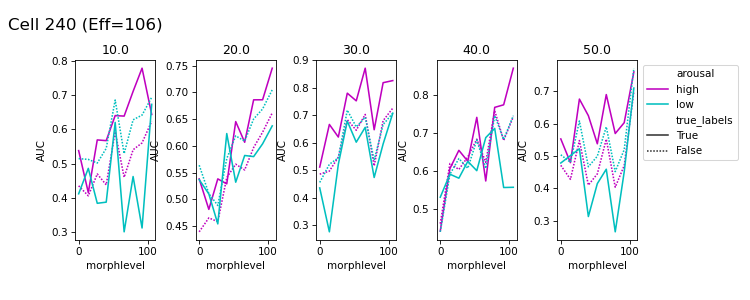

In [246]:
sizes= sorted(auc_r['size'].unique())

eff = int(auc_r['Eff'].unique())

fig, axn = pl.subplots(1,len(sizes), figsize=(10,4))
for ax, (sz, sg) in zip(axn.flat, auc_r[auc_r['Eff']==eff].groupby(['size'])):
    sns.lineplot(x='morphlevel', y='AUC', hue='arousal', data=sg, ax=ax,
                style_order=[True, False], dashes=dashes, style='true_labels', palette=arousal_colors)
    ax.legend_.remove()
    ax.set_title(sz)

axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left')
fig.text(0.01, 0.9, 'Cell %i (Eff=%i)' % (rid, eff), fontsize=16)
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5)

figname = '%s_%s_rid%03d_AUC' % (va, dk, rid)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

# Aggregate AUC, split_pupil

In [ ]:
# f
#     auc_fov = load_split_pupil_AUC(dk, single_eff=single_eff, allow_negative=allow_negative)


# Load split pupil fits

In [217]:
from psignifit import getSigmoidHandle as getSig


In [223]:
print(sigmoid_dir)

roi_fit_fns = glob.glob(os.path.join(rootdir, 'JC*', '2019*', 'FOV*', 'combined_blobs_static', 
                                  'traces', 'traces001*', 'neurometric', 'split_pupil', 
                                  'fits', sigmoid_dir, 'meanAUC_*.pkl'))
len(roi_fit_fns)

gauss_reverse


2330

In [220]:
r_ = []
for rfn in roi_fit_fns:

    with open(rfn, 'rb') as f:
        rd = pkl.load(f)
    #print( rdict.keys())
    if isinstance(rd, dict):
        print(rfn)
        continue
    #r_.extend([v for k, v in rdict.items()])
    r_.append(rd)
    
roifits = pd.concat(r_, axis=0)



# missing={}
# r_=[]
# for (va, dk), g in pAUC.groupby(['visual_area', 'datakey']):
#     #print(va, dk)
#     curr_fits, curr_miss = p3.load_fitparams(dk, roi_list=g['cell'].unique(),
#                                  allow_negative=allow_negative, sigmoid=sigmoid, split_pupil=True,
#                                  return_dicts=False, return_missing=True)
#     r_.append(curr_fits)
#     if len(curr_miss)>0:
#         missing[(va, dk)] = curr_miss
    
# roifits = pd.concat(r_).reset_index(drop=True)


In [221]:
roifits[roifits['threshold']>2]


Empty DataFrame
Columns: [threshold, width, lambda, gamma, eta, slope, thr, visual_area, datakey, cell, size, Eff, arousal, true_labels]
Index: []

In [164]:
# dk ='20191006_JC110_fov1'
# va='V1'
# rfits, missing_ = p3.load_fitparams(dk, roi_list=None, allow_negative=True,
#                   split_pupil=True, sigmoid='gauss', return_dicts=False, return_missing=True)

In [165]:
# traceid_dir = p3.get_tracedir_from_datakey(dk)
# rfn = glob.glob(os.path.join(traceid_dir, 'neurometric', 'split_pupil', 'fits', sigmoid_dir, 'meanAUC_*.pkl'))[0]

# with open(rfn, 'rb') as f:
#     rd = pkl.load(f)
# rd.keys()

In [224]:
roifits[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

datakey  cell
visual_area               
Li               126   126
Lm              1056  1056
V1              1148  1148

In [225]:
va='V1'
dk = '20191006_JC110_fov1'
v1 = roifits[(roifits.visual_area==va) & (roifits.datakey==dk) 
        & (~roifits.true_labels) & (roifits.arousal=='high')]

v2 = roifits[(roifits.visual_area==va) & (roifits.datakey==dk) 
        & (~roifits.true_labels) & (roifits.arousal=='low')]
np.where(v1['threshold'].values!=v2['threshold'].values)

(array([  0,   1,   2,   3,   4,   5,   6,  10,  11,  12,  13,  15,  18,
         19,  20,  25,  26,  27,  30,  33,  35,  37,  38,  40,  41,  43,
         44,  45,  46,  50,  51,  53,  54,  55,  56,  57,  60,  62,  63,
         65,  66,  67,  68,  69,  70,  74,  75,  79,  80,  81,  82,  83,
         85,  87,  88,  89,  90,  91,  95,  96,  97,  98,  99, 100, 102,
        103, 105, 108, 110, 111, 112, 115, 117, 119, 120, 121, 122, 124,
        125, 127, 128, 129, 130, 131, 134, 135, 136, 140, 143, 145, 146,
        147, 150, 153, 155, 158, 160, 162, 163, 165, 166, 167, 168, 170,
        175, 178, 180, 185, 186, 187, 188, 189, 190, 191, 194, 195, 196,
        197, 199, 200, 201, 203, 205, 207, 210, 211, 212, 213, 215, 216,
        217, 218, 219, 220, 221, 223, 225, 226, 227, 228, 229, 230, 232,
        233, 235, 236, 237, 240, 245, 248, 250, 251, 252, 253, 254, 255,
        258, 260, 261, 262, 264, 265, 266, 267, 270, 271, 272, 273, 274,
        275, 277, 278, 280, 281, 283, 284, 285, 286

In [226]:
v1

threshold     width        lambda  gamma           eta     slope  \
61    1.072908  0.244253  2.081596e-07    0.5  3.965469e-08  2.686562   
61    1.099343  0.242435  1.363723e-09    0.5  7.993276e-06  2.706713   
61    1.056973  0.244652  2.376213e-04    0.5  7.551355e-08  2.680909   
61    1.093626  0.243784  2.733759e-08    0.5  3.122183e-08  2.691738   
61    1.094928  0.242650  3.107991e-07    0.5  4.972582e-06  2.704316   
..         ...       ...           ...    ...           ...       ...   
301   1.115854  0.241960  4.659255e-06    0.5  5.813632e-08  2.711998   
301   1.097949  0.241799  5.146017e-08    0.5  6.091432e-06  2.713828   
301   1.098668  0.242639  3.827987e-08    0.5  3.111390e-07  2.704439   
301   1.093626  0.243784  2.733759e-08    0.5  3.122183e-08  2.691738   
301   1.094628  0.242899  1.132221e-07    0.5  1.286722e-06  2.701537   

          thr visual_area              datakey  cell  size  Eff arousal  \
61   1.072908          V1  20191006_JC110_fov1    61  10.0  106    high   
61   1.099343          V1  20191006_JC110_fov1    61  20.0  106    high   
61   1.057017          V1  20191006_JC110_fov1    61  30.0  106    high   
61   1.093626          V1  20191006_JC110_fov1    61  40.0  106    high   
61   1.094928          V1  20191006_JC110_fov1    61  50.0  106    high   
..        ...         ...                  ...   ...   ...  ...     ...   
301  1.115855          V1  20191006_JC110_fov1   301  10.0    0    high   
301  1.097949          V1  20191006_JC110_fov1   301  20.0    0    high   
301  1.098668          V1  20191006_JC110_fov1   301  30.0    0    high   
301  1.093626          V1  20191006_JC110_fov1   301  40.0    0    high   
301  1.094628          V1  20191006_JC110_fov1   301  50.0    0    high   

     true_labels  
61         False  
61         False  
61         False  
61         False  
61         False  
..           ...  
301        False  
301        False  
301        False  
301        False  
301        False  

[380 rows x 14 columns]

In [247]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/split_pupil/gauss_reverse'

In [228]:
# onefit = pd.concat([g for r, g in rfits.groupby(['visual_area', 'datakey', 'cell']) \
#                 if len(g['Eff'].unique())==1])
# onefit[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()

onefit = pd.concat([g for r, g in roifits.groupby(['visual_area', 'datakey', 'cell']) \
                if len(g[g.true_labels]['Eff'].unique())==1])
onefit[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count()


print(onefit[onefit['Eff']==0][['visual_area', 'datakey', 'cell']]\
                .drop_duplicates().groupby(['visual_area']).count())
print(onefit[onefit['Eff']==106][['visual_area', 'datakey', 'cell']]\
                .drop_duplicates().groupby(['visual_area']).count())

             datakey  cell
visual_area               
Li                62    62
Lm               650   650
V1               814   814
             datakey  cell
visual_area               
Li                64    64
Lm               406   406
V1               334   334


In [229]:
# roifits[(roifits.visual_area=='Li') & (roifits.datakey=='20190602_JC091_fov1')].round(5)
roifits[(roifits.visual_area=='V1') & (roifits.datakey=='20191006_JC110_fov1')].round(5)

threshold    width  lambda  gamma      eta     slope       thr  \
61     1.07291  0.24425  0.0000    0.5  0.00000  2.686562  1.072908   
61     1.11548  0.24197  0.0000    0.5  0.00033  2.711965   1.11548   
61     1.07339  0.24482  0.0002    0.5  0.00000  2.679276   1.07343   
61     1.07496  0.24434  0.0000    0.5  0.00000  2.685564  1.074962   
61     1.09934  0.24243  0.0000    0.5  0.00001  2.706713  1.099343   
..         ...      ...     ...    ...      ...       ...       ...   
301    1.09363  0.24378  0.0000    0.5  0.00000  2.691738  1.093626   
301    1.09463  0.24290  0.0000    0.5  0.00000  2.701537  1.094628   
301    1.09363  0.24378  0.0000    0.5  0.00000  2.691738  1.093626   
301    1.09463  0.24290  0.0000    0.5  0.00000  2.701537  1.094628   
301    1.09552  0.24289  0.0000    0.5  0.00000  2.701638  1.095522   

    visual_area              datakey  cell  size  Eff arousal  true_labels  
61           V1  20191006_JC110_fov1    61  10.0  106    high        False  
61           V1  20191006_JC110_fov1    61  10.0  106    high         True  
61           V1  20191006_JC110_fov1    61  10.0  106     low        False  
61           V1  20191006_JC110_fov1    61  10.0  106     low         True  
61           V1  20191006_JC110_fov1    61  20.0  106    high        False  
..          ...                  ...   ...   ...  ...     ...          ...  
301          V1  20191006_JC110_fov1   301  40.0    0     low         True  
301          V1  20191006_JC110_fov1   301  50.0    0    high        False  
301          V1  20191006_JC110_fov1   301  50.0    0    high         True  
301          V1  20191006_JC110_fov1   301  50.0    0     low        False  
301          V1  20191006_JC110_fov1   301  50.0    0     low         True  

[1520 rows x 14 columns]

<IPython.core.display.Javascript object>


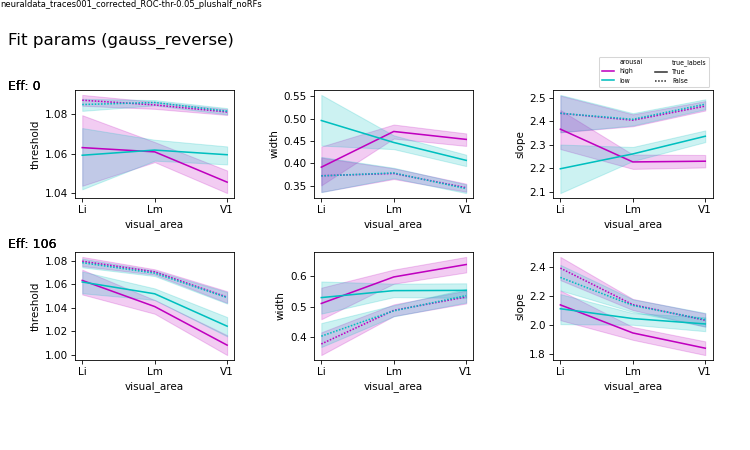

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/split_pupil/gauss_reverse aggr_param_avgs_split_conds__lineplots


In [256]:
par = 'threshold'

plotparams = ['threshold', 'width', 'slope'] #, 'thr', 'width', 'slope']
for p in plotparams:
    onefit[p] = onefit[p].astype(float)
    
fig, axn = pl.subplots(2, len(plotparams), figsize=(10,6))

for pi, par in enumerate(plotparams):
    eff=0
    ax=axn[0, pi]
    fig.text(0.01, 0.8, 'Eff: %i' % eff, fontsize=12)
    sns.lineplot(x='visual_area', y=par, data=onefit[onefit['Eff']==0].dropna(), ax=ax,
                 hue='arousal', style='true_labels', style_order=[True, False], dashes=dashes,
                palette=arousal_colors) #onefit[par]
    ax.legend_.remove()
    
    ax=axn[1, pi]
    eff=106
    fig.text(0.01, 0.45, 'Eff: %i' % eff, fontsize=12)
    sns.lineplot(x='visual_area', y=par, data=onefit[onefit['Eff']==eff].dropna(), ax=ax,
             hue='arousal', style='true_labels', style_order=[True, False], dashes=dashes,
                palette=arousal_colors) #onefit[par]
    ax.legend_.remove()
    
axn[0, len(plotparams)-1].legend(bbox_to_anchor=(1, 1), loc='lower right', fontsize=6, ncol=2)
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.5, hspace=0.5)

p3.label_figure(fig, data_id)

fig.text(0.01, 0.9, 'Fit params (%s)' % sigmoid_dir, fontsize=16)
figname = 'aggr_param_avgs_split_conds__lineplots' 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)

<IPython.core.display.Javascript object>


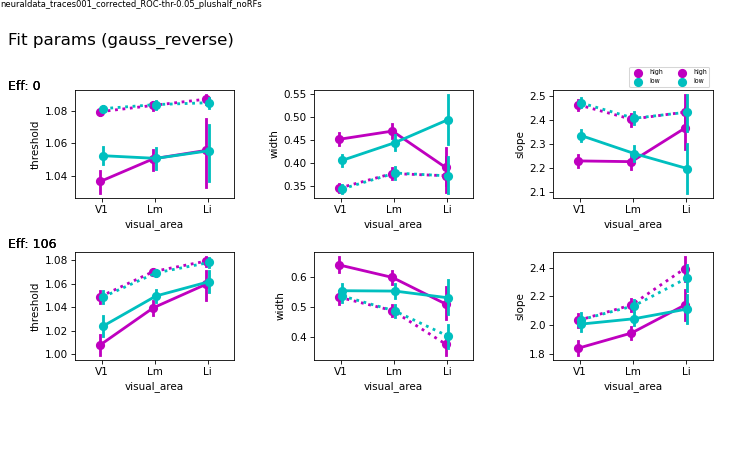

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/split_pupil/gauss_reverse aggr_param_avgs_split_conds__shuffle-v-true


In [257]:

plotparams = ['threshold', 'width', 'slope'] #, 'thr', 'width', 'slope']
  
fig, axn = pl.subplots(2, len(plotparams), figsize=(10,6))

for pi, par in enumerate(plotparams):
    ax=axn[0, pi]
    eff=0
    df = onefit[onefit['Eff']==eff]
    fig.text(0.01, 0.8, 'Eff: %i' % eff, fontsize=12)
    sns.pointplot(x='visual_area', y=par, data=df[df.true_labels], ax=ax, 
                 order=visual_areas, hue='arousal', palette=arousal_colors, dodge=True)

    sns.pointplot(x='visual_area', y=par, data=df[~df.true_labels], ax=ax, 
                 order=visual_areas, hue='arousal', palette=arousal_colors, dodge=True, linestyles=':')
    ax.legend_.remove()
    ax=axn[1, pi]
    eff=106
    df = onefit[onefit['Eff']==eff]
    fig.text(0.01, 0.45, 'Eff: %i' % eff, fontsize=12)
    sns.pointplot(x='visual_area', y=par, data=df[df.true_labels], ax=ax, 
                 order=visual_areas, hue='arousal', palette=arousal_colors, dodge=True)

    sns.pointplot(x='visual_area', y=par, data=df[~df.true_labels], ax=ax, 
                 order=visual_areas, hue='arousal', palette=arousal_colors, dodge=True, linestyles=':')
    
    ax.legend_.remove()
axn[0, len(plotparams)-1].legend(bbox_to_anchor=(1, 1), loc='lower right', fontsize=6, ncol=2)
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.5, hspace=0.5)



p3.label_figure(fig, data_id)

fig.text(0.01, 0.9, 'Fit params (%s)' % sigmoid_dir, fontsize=16)
figname = 'aggr_param_avgs_split_conds__shuffle-v-true' 
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

print(dst_dir, figname)


In [511]:
parnames

['threshold', 'width', 'thr', 'slope', 'lambda', 'eta']

In [171]:

va='V1'
dk='20191006_JC110_fov1'
curr_fits = onefit[(onefit.visual_area==va) & (onefit.datakey==dk)]
pass_cells = [r for r, g in curr_fits.groupby(['cell']) if len(g["Eff"].unique())==1]
# pass_cells

[4,
 5,
 6,
 11,
 12,
 24,
 33,
 38,
 46,
 55,
 61,
 76,
 77,
 79,
 85,
 86,
 100,
 104,
 106,
 107,
 108,
 116,
 118,
 121,
 128,
 131,
 133,
 140,
 141,
 152,
 153,
 167,
 170,
 172,
 175,
 178,
 182,
 187,
 198,
 215,
 216,
 223,
 225,
 228,
 230,
 232,
 235,
 240,
 242,
 243,
 248,
 252,
 255,
 267,
 275,
 276,
 279,
 285,
 298,
 301,
 302,
 304,
 305,
 307,
 310,
 325,
 336,
 337,
 338,
 353,
 354,
 355,
 364,
 380,
 383,
 390]

In [172]:
curr_fits[curr_fits['Eff'].isin([0, 106])]['cell'].unique()

array([  4,   5,   6,  11,  12,  24,  33,  38,  46,  55,  61,  76,  77,
        79,  85,  86, 100, 104, 106, 107, 108, 116, 118, 121, 128, 131,
       133, 140, 141, 152, 153, 167, 170, 172, 175, 178, 182, 187, 198,
       215, 216, 223, 225, 228, 230, 232, 235, 240, 242, 243, 248, 252,
       255, 267, 275, 276, 279, 285, 298, 301, 302, 304, 305, 307, 310,
       325, 336, 337, 338, 353, 354, 355, 364, 380, 383, 390])

In [232]:
parnames = ['threshold', 'width', 'thr', 'slope', 'lambda', 'eta']

In [233]:
# fitpars = onefit[(onefit['threshold']<=106) & (onefit['threshold']>=0)]
#              & (onefit['width']<=106*1.5) & (onefit['lambda']>0)].copy()


fitpars = onefit.copy()


<IPython.core.display.Javascript object>


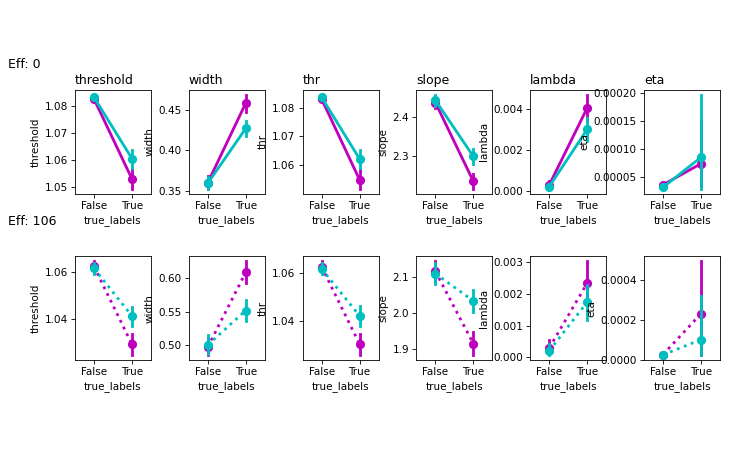

In [258]:
fig, axn = pl.subplots(2, len(parnames), figsize=(10,6))

for pi, par in enumerate(parnames):
    ax=axn[0, pi]
    sns.pointplot(x='true_labels', y=par, hue='arousal', data=fitpars[fitpars['Eff']==0].dropna(), 
                 palette=arousal_colors, linestyles='-', ax=ax)
    ax.set_title(par, loc='left')
#     if par in ['threshold', 'thr']:
#         ax.set_ylim([0, 106])
    ax.legend_.remove()
    
    ax=axn[1, pi]
    sns.pointplot(x='true_labels', y=par, hue='arousal', data=fitpars[fitpars['Eff']==106].dropna(), 
                 palette=arousal_colors, linestyles=':', ax=ax)
    
    ax.legend_.remove()
fig.text(0.01, 0.85, 'Eff: 0', fontsize=12)
fig.text(0.01, 0.5, 'Eff: 106', fontsize=12)

pl.subplots_adjust(left=0.1, right=0.96, bottom=0.2, top=0.8, wspace=0.5, hspace=0.6)

In [236]:
# sig = 'gauss'
# f_=[]
# for (va, dk, ci, eff, ar, tru), fpars in onefit.groupby(['visual_area', 'datakey', 'cell', 'Eff', 'arousal', 'true_labels']):
#     # Get current sigmoid
#     opts = default_options()
#     eff = int(fpars['Eff'].unique())
#     opts['sigmoidName'] = 'neg_%s' % sig if eff==0 else sig
#     fh = getSig.getSigmoidHandle(opts)
    
#     # interpolate points
#     fvs = fpars.groupby(['size', 'arousal', 'true_labels'], as_index=False)\
#                 .apply(get_fit_values, fh, xmin=0, xmax=106, npoints=50).reset_index(drop=True)
#     fvs['arousal'] = ar
#     fvs['true_labels'] = tru
#     fvs['Eff'] = eff
#     f_.append(fvs)
    
print(allow_negative)
opts = p3.default_options()
f_=[]
for (va, dk, ci, sz, arous, tru), g in onefit.groupby(['visual_area', 'datakey', 'cell', 'size',
                                          'arousal', 'true_labels']):
    eff = int(g['Eff'].unique())
    opts['sigmoidName'] = 'neg_%s' % sigmoid if (eff==0 and allow_negative) else sigmoid
    fh = getSig.getSigmoidHandle(opts)
    fvs = p3.get_fit_values(g, fh, xmin=0, xmax=1, npoints=50)
    fvs['arousal'] = arous
    fvs['true_labels'] = tru
    fvs['Eff'] = eff
    
    f_.append(fvs)
    
fitvs = pd.concat(f_)

False


In [237]:
FITY = pd.concat(f_)
FITY.head()

x  fitv visual_area              datakey  cell  size  Eff arousal  \
0  0.000000   0.5          Li  20190422_JC076_fov1    76  10.0  106    high   
1  0.020408   0.5          Li  20190422_JC076_fov1    76  10.0  106    high   
2  0.040816   0.5          Li  20190422_JC076_fov1    76  10.0  106    high   
3  0.061224   0.5          Li  20190422_JC076_fov1    76  10.0  106    high   
4  0.081633   0.5          Li  20190422_JC076_fov1    76  10.0  106    high   

   true_labels  
0        False  
1        False  
2        False  
3        False  
4        False

In [238]:
FITY[['visual_area', 'datakey']].drop_duplicates().groupby(['visual_area']).count()

datakey
visual_area         
Li                 3
Lm                13
V1                11

In [185]:
fpars[(fpars['Eff']==eff) & (fpars.true_labels)]

x      fitv visual_area              datakey  cell  size  Eff  \
0      0.000000  0.747062          V1  20190501_JC076_fov1   200  10.0    0   
1      2.163265  0.737836          V1  20190501_JC076_fov1   200  10.0    0   
2      4.326531  0.728636          V1  20190501_JC076_fov1   200  10.0    0   
3      6.489796  0.719482          V1  20190501_JC076_fov1   200  10.0    0   
4      8.653061  0.710392          V1  20190501_JC076_fov1   200  10.0    0   
..          ...       ...         ...                  ...   ...   ...  ...   
245   97.346939  0.512666          V1  20190501_JC076_fov1   200  50.0    0   
246   99.510204  0.510933          V1  20190501_JC076_fov1   200  50.0    0   
247  101.673469  0.509405          V1  20190501_JC076_fov1   200  50.0    0   
248  103.836735  0.508063          V1  20190501_JC076_fov1   200  50.0    0   
249  106.000000  0.506888          V1  20190501_JC076_fov1   200  50.0    0   

    arousal  true_labels  
0      high         True  
1      high         True  
2      high         True  
3      high         True  
4      high         True  
..      ...          ...  
245     low         True  
246     low         True  
247     low         True  
248     low         True  
249     low         True  

[500 rows x 9 columns]

In [187]:
mean_thr

Empty DataFrame
Columns: [threshold, width, lambda, gamma, eta, slope, cell, size, Eff, true_labels]
Index: []

In [182]:
curr_dst_dir = os.path.join(dst_dir,'split_pupil', 'examples')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/split_pupil/examples


In [183]:
import matplotlib.patches as patches

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/relational.py:936: UserWarning: relplot is a figure-level function and does not accept the ax= paramter. You may wish to try lineplot
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


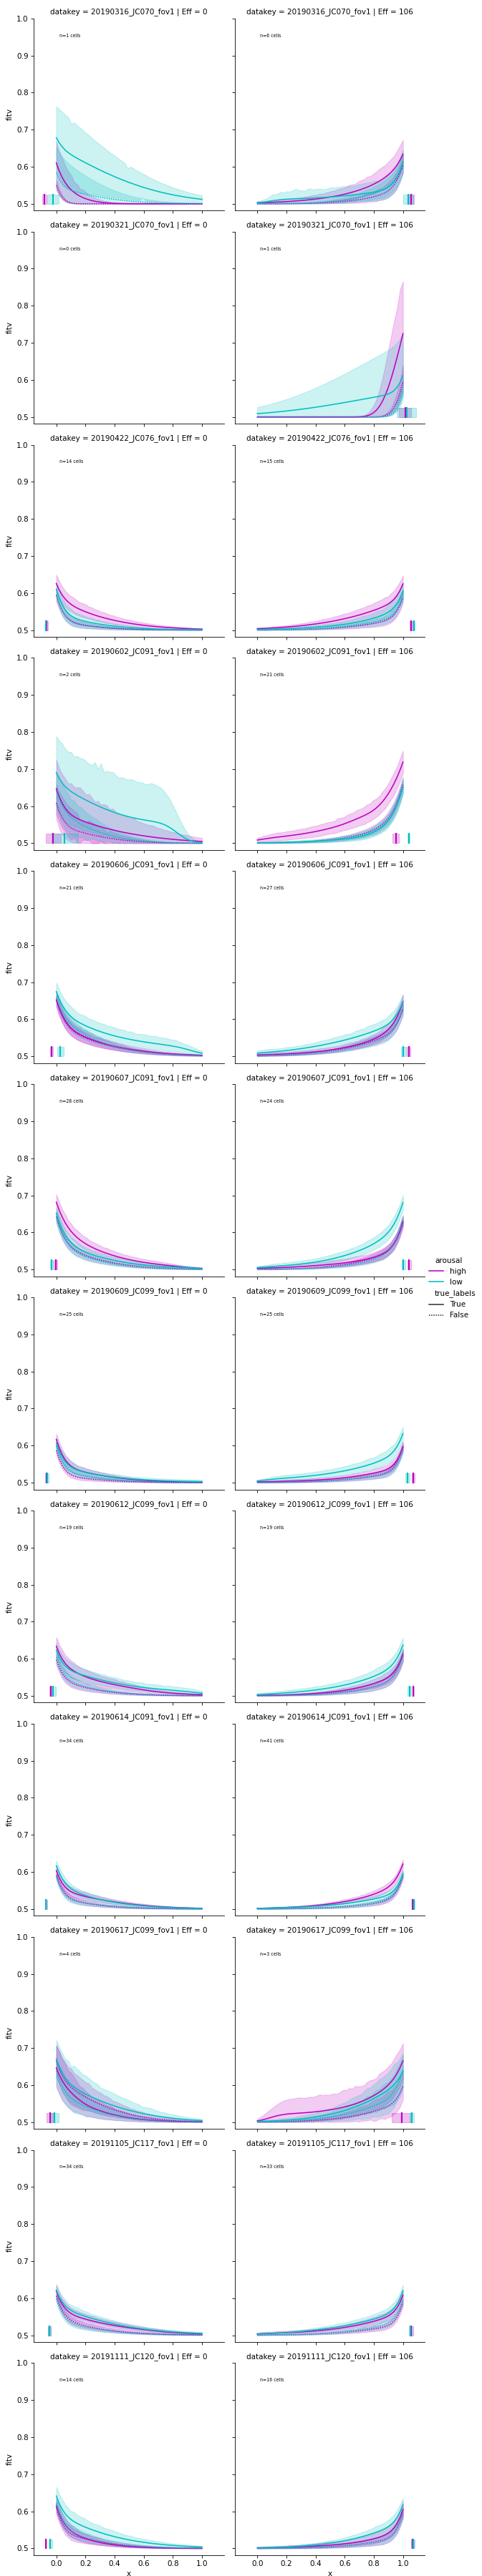

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/relational.py:936: UserWarning: relplot is a figure-level function and does not accept the ax= paramter. You may wish to try lineplot
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


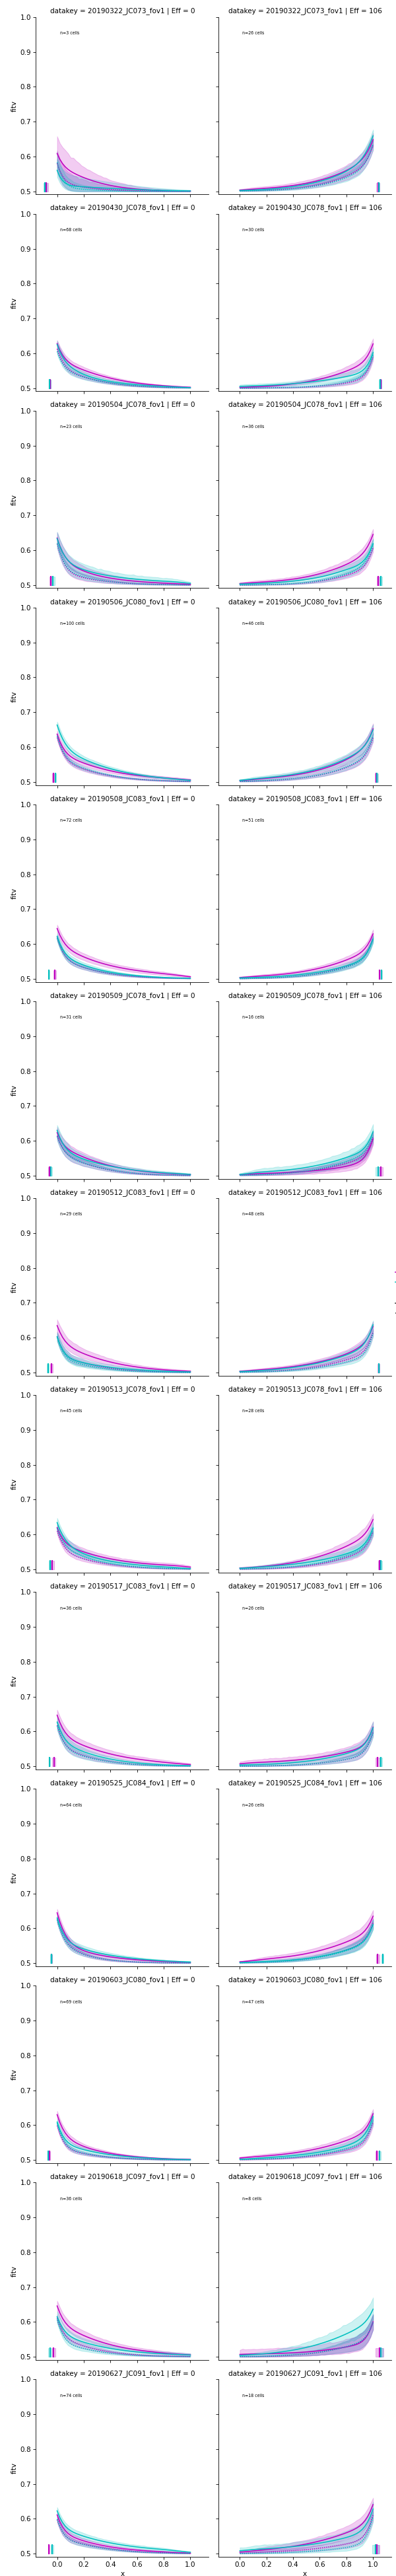

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/relational.py:936: UserWarning: relplot is a figure-level function and does not accept the ax= paramter. You may wish to try lineplot
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


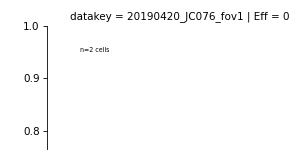

In [187]:
va = 'V1'
dk = '20191006_JC110_fov1'

#for dk in 
#fv = FITY[(FITY.visual_area==va) & (FITY.datakey==dk)].copy()
for va, fv in FITY.groupby(['visual_area']):
#fv = FITY[(FITY.visual_area==va)].copy()

    fg = sns.relplot(x='x', y='fitv', data=fv, ax=ax,
                 hue='arousal', palette=arousal_colors, 
                style='true_labels', dashes=dashes, style_order=[True, False],
                col='Eff', row='datakey', kind='line', height=4, )
    #pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8)
    #ncells = len(fv['cell'].unique())

    H = 0.525
    ymin = 0.5
    for (dk, eff), ax in fg.axes_dict.items():
        fpars = onefit[(onefit.visual_area==va) & (onefit.datakey==dk) & (onefit['Eff']==eff)]
        ncells = len(fpars['cell'].unique())
        ax.text(0.02, 0.95, 'n=%i cells' % ncells, fontsize=6)
        
        ax.set_ylim([ax.get_ylim()[0], 1])
        try:
            mean_thr = fpars[(fpars['Eff']==eff) & (fpars.true_labels)].groupby(['arousal']).mean()
            sem_thr = fpars[(fpars['Eff']==eff) & (fpars.true_labels)].groupby(['arousal']).sem()
            for a_ in ['high', 'low']:
                thr_hi = mean_thr.loc[a_]['threshold']
                sd_hi = sem_thr.loc[a_]['threshold']
                ax.plot([thr_hi, thr_hi], [ymin, H], color=arousal_colors[a_], lw=2)

                ax.add_patch(patches.Rectangle(
                    xy=(thr_hi-sd_hi, ymin),  # point of origin.
                    width=sd_hi*2.,
                    height=H-ymin,
                    linewidth=1,
                    color=arousal_colors[a_],
                    fill=True, alpha=0.25) )
        except Exception as e:
            continue

    figname = 'avg_curves_%s' % (va)
    pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))

In [189]:
curr_dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit/split_pupil/examples'

In [184]:
mean_thr = fpars[(fpars['Eff']==eff)].groupby(['arousal', 'true_labels']).mean()
mean_thr.loc['high', False]['threshold']

NameError: name 'fpars' is not defined

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/relational.py:936: UserWarning: relplot is a figure-level function and does not accept the ax= paramter. You may wish to try lineplot
  warnings.warn(msg, UserWarning)


<IPython.core.display.Javascript object>


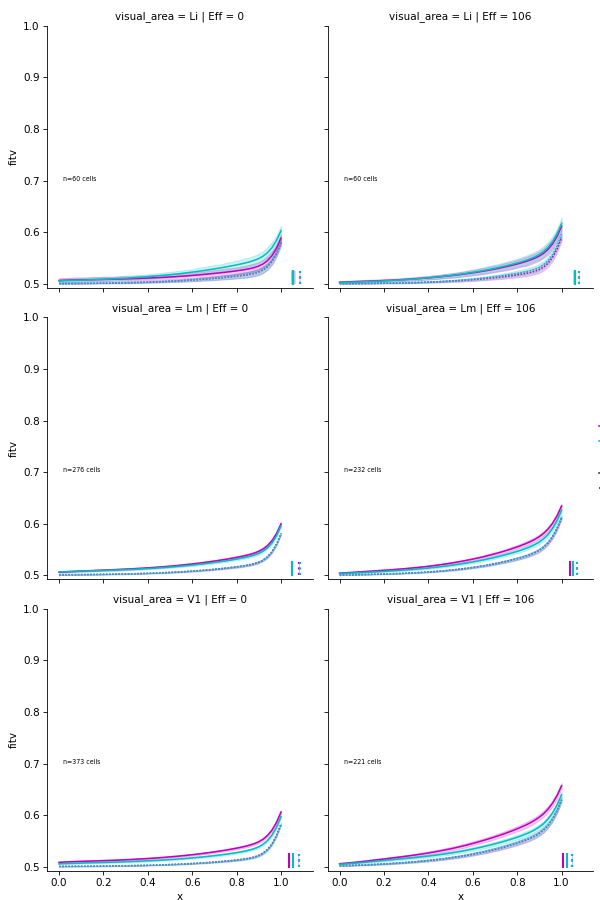

high True 1.0557617433663045 0.010186936466028512
high False 1.0869731973156227 0.0013363093788426766
low True 1.055530190379594 0.009007037623328907
low False 1.0847882523971981 0.0015320773303820411
high True 1.059730450052373 0.006334375002947735
high False 1.0794009094124164 0.0018938877633946
low True 1.0618328175182152 0.004741441213902536
low False 1.0781921991937167 0.0018230703209352014
high True 1.0506246009358013 0.0032035674401734507
high False 1.0831379514500068 0.0012127528501670632
low True 1.0508714672787574 0.003312823853733937
low False 1.0836391591115018 0.001131652426816417
high True 1.0395326698214642 0.003190671155442732
high False 1.0704442620946693 0.001170824369972898
low True 1.049605529878785 0.002763180278459149
low False 1.069316377553336 0.001183260736109415
high True 1.0367823532083342 0.0032857249177004303
high False 1.0793029226572115 0.0010396590102058618
low True 1.0524898231925925 0.002698500453557254
low False 1.0811658898513834 0.000856442703764261

In [259]:
#va='V1'
#for va, fv in FITY.groupby(['visual_area']):
#fv = FITY[(FITY.visual_area==va)].copy()

fg = sns.relplot(x='x', y='fitv', data=FITY, ax=ax,
             hue='arousal', palette=arousal_colors, 
            style='true_labels', dashes=dashes, style_order=[True, False],
            col='Eff', row='visual_area', kind='line', height=4, )

# ncells = len(fv[['datakey', 'cell']].drop_duplicates())

H = 0.525
ymin = 0.5
for (va, eff), ax in fg.axes_dict.items():
    fpars = onefit[(onefit.visual_area==va) & (onefit['Eff']==eff)]
    ncells = len(fpars['cell'].unique())
    ax.text(0.02, 0.7, 'n=%i cells' % ncells, fontsize=6)
    ax.set_ylim([ax.get_ylim()[0], 1])
    try:
        mean_thr = fpars[(fpars['Eff']==eff)].groupby(['arousal', 'true_labels']).mean()
        sem_thr = fpars[(fpars['Eff']==eff)].groupby(['arousal', 'true_labels']).sem()
        for a_ in ['high', 'low']:
            for s_ in [True, False]:
                thr_hi = mean_thr.loc[a_, s_]['threshold']
                sd_hi = sem_thr.loc[a_, s_]['threshold']
                print(a_, s_, thr_hi, sd_hi)
                ls='-' if s_ else ':'
                ax.plot([thr_hi, thr_hi], [ymin, H], color=arousal_colors[a_], lw=2, linestyle=ls)
                ax.add_patch(patches.Rectangle(
                    xy=(thr_hi-sd_hi, ymin),  # point of origin.
                    width=sd_hi*2., height=H-ymin,
                    linewidth=0, color=arousal_colors[a_], fill=True, alpha=0.2) )
    except Exception as e:
        continue
        
figname = 'avg_curves_aggr_cells'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))



In [270]:
fitpars = onefit0.copy().reset_index(drop=True)
fitpars = fitpars.dropna()


In [271]:
fitpars

['threshold', 'width', 'thr', 'slope', 'lambda', 'eta']

In [272]:

fitpars['thr_dist'] = None
fitpars['thr_dist_abs'] = None

for eff, g in fitpars.groupby(['Eff']):
    fitpars.loc[g.index, 'thr_dist'] = g['threshold'] - eff

fitpars['thr_dist_abs'] = fitpars['thr_dist'].abs()

In [293]:
fitpars['abs_slope'] = fitpars['slope'].abs()

<IPython.core.display.Javascript object>


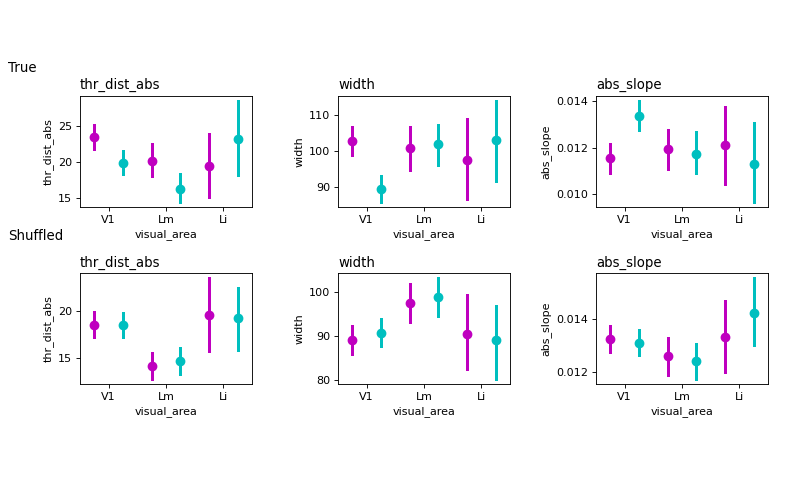

In [301]:
par = 'thr_dist_abs'
fig, axn = pl.subplots(2, 3, figsize=(10,6))
for pi, par in enumerate(['thr_dist_abs', 'width', 'abs_slope']):
    ax=axn[0, pi]
    sns.pointplot(x='visual_area', y=par, hue='arousal', data=fitpars[fitpars.true_labels],
                 palette=arousal_colors, linestyles='-', ax=ax, dodge=0.5, size=3, join=False,
                 order=visual_areas)
    ax.set_title(par, loc='left')
    ax.legend_.remove()

    ax=axn[1, pi]
    sns.pointplot(x='visual_area', y=par, hue='arousal', data=fitpars[~fitpars.true_labels],
                 palette=arousal_colors, linestyles='-', ax=ax, dodge=0.5, size=3, join=False,
                  order=visual_areas)
    ax.set_title(par, loc='left')

    ax.legend_.remove()
    
#     ax=axn[1, pi]
#     sns.pointplot(x='true_labels', y=par, hue='arousal', data=fitpars[fitpars['Eff']==106].dropna(), 
#                  palette=arousal_colors, linestyles=':', ax=ax)
    
#     ax.legend_.remove()
fig.text(0.01, 0.85, 'True', fontsize=12)
fig.text(0.01, 0.5, 'Shuffled', fontsize=12)

pl.subplots_adjust(left=0.1, right=0.96, bottom=0.2, top=0.8, wspace=0.5, hspace=0.6)

figname = 'avg_params_by_arousal_shuffcond'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [275]:
import pingouin as pg

In [ ]:
pvals = reject, pvals_corr = pg.multicomp(pvals, method='fdr_bh')

In [ ]:
x = fitpars[fitpars.true_labels]
spstats.mannwhitneyu(x, y)


In [280]:
fitpars['visual_area'] = fitpars['visual_area'].astype('category')
fitpars['arousal'] = fitpars['arousal'].astype('category')

fitpars.dtypes

threshold        float64
width            float64
lambda           float64
gamma            float64
eta              float64
slope            float64
thr               object
visual_area     category
datakey           object
cell               int64
size             float64
Eff                int64
arousal         category
true_labels         bool
thr_dist          object
thr_dist_abs      object
dtype: object

In [286]:
# aov = pg.mixed_anova(data=fitpars[fitpars.true_labels], 
#                      dv='threshold', within='arousal', between='visual_area')

aov = pg.anova(data=fitpars[fitpars.true_labels], 
                     dv='threshold',between=['visual_area', 'arousal'])

In [290]:
aov2 = pg.anova(data=fitpars[~fitpars.true_labels], 
                     dv='threshold',between=['visual_area', 'arousal'])
aov2.round(3)

Source            SS      DF         MS       F  p-unc  \
0            visual_area  8.720057e+04     2.0  43600.287  16.377   0.00   
1                arousal  4.382581e+03     1.0   4382.581   1.646   0.20   
2  visual_area * arousal  1.609210e+02     2.0     80.461   0.030   0.97   
3               Residual  1.313065e+07  4932.0   2662.337     NaN    NaN   

     np2  
0  0.007  
1  0.000  
2  0.000  
3    NaN

In [292]:
aov.round(3)

Source           SS      DF         MS       F  p-unc    np2
0            visual_area    87236.852     2.0  43618.426  21.747  0.000  0.014
1                arousal     1379.830     1.0   1379.830   0.688  0.407  0.000
2  visual_area * arousal     5944.927     2.0   2972.464   1.482  0.227  0.001
3               Residual  6366235.852  3174.0   2005.745     NaN    NaN    NaN

In [287]:
pg.__version__

'0.3.10'

In [242]:
p = 'threshold'
fg = sns.FacetGrid(onefit0, row='Eff', col='visual_area', col_order=visual_areas, height=2)
fg.map(sns.pointplot,x='true_labels', y='threshold', hue='arousal', palette=arousal_colors, dodge=True)


<IPython.core.display.Javascript object>

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/seaborn/axisgrid.py:643: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


ValueError: Could not interpret input 'true_labels'

# Example cells

In [302]:
va='V1'
curr_datakey ='20191006_JC110_fov1'

traceid_dir = get_tracedir_from_datakey(curr_datakey)

auc_outfile = glob.glob(os.path.join(traceid_dir, 'neurometric', 'split_pupil', 'mean_aucs.pkl'))[0]
with open(auc_outfile, 'rb') as f:
    auc_fov = pkl.load(f)
    

In [303]:
[k for k, g in auc_fov.groupby(['cell']) if len(g['Eff'].unique())==1]

[131, 240, 307, 353, 364]

In [304]:
curr_dst_dir = os.path.join(traceid_dir, 'neurometric', 'split_pupil', 'examples')
if not os.path.exists(curr_dst_dir):
    os.makedirs(curr_dst_dir)
print(curr_dst_dir)

curr_id = '%s|%s|%s' % (data_id, va, dk)
print(curr_id)

/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_3b3744_traces001_1990cb_traces001_58a59f_traces001_c760ae_traces001_00f36c_traces001_6f6bcc_traces001_13f7f0/neurometric/split_pupil/examples
neuraldata_traces001_corrected_ROC-thr-0.05_plushalf_noRFs|V1|20191006_JC110_fov1


In [329]:
### 1 cell, AUC:
rid=131
auc_r = auc_fov[auc_fov['cell']==rid]
auc_r.head()

visual_area              datakey  cell arousal  true_labels  morphlevel  \
9855          V1  20191006_JC110_fov1   131    high        False           0   
9856          V1  20191006_JC110_fov1   131    high        False           0   
9857          V1  20191006_JC110_fov1   131    high        False           0   
9858          V1  20191006_JC110_fov1   131    high        False           0   
9859          V1  20191006_JC110_fov1   131    high        False           0   

      size  Eff  index       AUC  n_trials  iteration  n_chooseB  
9855  10.0    0    0.0  0.398889       9.0       49.5    3.59000  
9856  20.0    0    8.0  0.520300      10.0       49.5    5.20300  
9857  30.0    0   16.0  0.556300      10.0       49.5    5.56300  
9858  40.0    0   24.0  0.751250       8.0       49.5    6.01000  
9859  50.0    0   32.0  0.732656       8.0       49.5    5.86125

In [330]:
data_id

'neuraldata_traces001_corrected_ROC-thr-0.05_plushalf_noRFs'

<IPython.core.display.Javascript object>


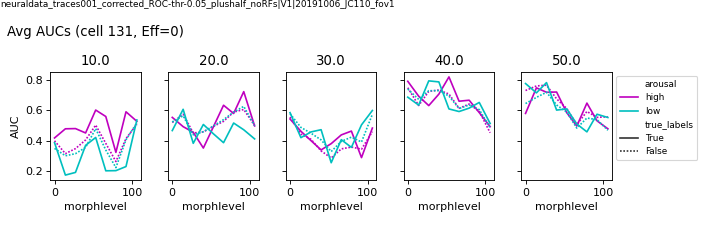

/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_3b3744_traces001_1990cb_traces001_58a59f_traces001_c760ae_traces001_00f36c_traces001_6f6bcc_traces001_13f7f0/neurometric/split_pupil/examples V1_20191006_JC110_fov1_rid131_auc
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit V1_20191006_JC110_fov1_rid131_auc


In [341]:
sizes= sorted(auc_r['size'].unique())
eff = int(auc_r['Eff'].unique())

fig, axn = pl.subplots(1,len(sizes), figsize=(9,3), sharex=True, sharey=True)
for ax, (sz, sg) in zip(axn.flat, auc_r[auc_r['Eff']==eff].groupby(['size'])):
    sns.lineplot(x='morphlevel', y='AUC', hue='arousal', data=sg, ax=ax,
                style_order=[True, False], dashes=dashes, style='true_labels', palette=arousal_colors)
    ax.legend_.remove()
    ax.set_title(sz)

axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left', fontsize=8)

fig.text(0.01, 0.85, 'Avg AUCs (cell %i, Eff=%i)' % (rid, eff), fontsize=12)
pl.subplots_adjust(left=0.07, right=0.85, bottom=0.25, top=0.7, wspace=0.3)
label_figure(fig, curr_id)

figname = '%s_%s_rid%03d_auc' % (va, dk, rid)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)
pl.savefig(os.path.join(dst_dir, 'split_pupil', 'examples', '%s.svg' % figname))
print(dst_dir, figname)


In [342]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit'

# Tets plotting from params

In [343]:
importlib.reload(ps)

<module 'psignifit' from '/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/__init__.py'>

In [344]:
# fiter = auc_r.groupby(['size', 'arousal', 'true_labels'], as_index=False)\
#         .apply(group_fit_psignifit, opts, allow_negative=allow_negative)



In [345]:
# fit_params = ['threshold', 'width', 'lambda', 'gamma','eta']
# fit, = curr_fparams[fit_params].values

# alpha = options['widthalpha']
# sigmoid = options['sigmoidName']
# PC = options['threshPC']       
sig='gauss'
opts = default_options()
opts['sigmoidName'] = 'neg_%s' % sig if eff==0 else sig
opts['sigmoidHandle'] = getSig.getSigmoidHandle(opts)
opts['widthalpha'] = .05


In [346]:
import copy

In [347]:
fiter = rfits[(rfits.visual_area==va) & (rfits.datakey==dk) & (rfits['cell']==rid)]


In [348]:
fh = getSig.getSigmoidHandle(opts)


fitvs = fiter.groupby(['size', 'arousal', 'true_labels'], as_index=False)\
            .apply(get_fit_values, fh, xmin=0, xmax=106, npoints=50).reset_index(drop=True)

add_cols= ['visual_area', 'datakey', 'cell', 'size', 'Eff', 'arousal', 'true_labels']


In [349]:
port_markers={'high':'o', 'low':'X'}
markers={True:'.', False:'.'}


<IPython.core.display.Javascript object>


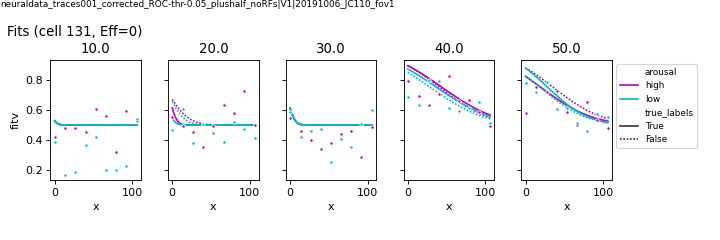

/n/coxfs01/2p-data/JC110/20191006/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_3b3744_traces001_1990cb_traces001_58a59f_traces001_c760ae_traces001_00f36c_traces001_6f6bcc_traces001_13f7f0/neurometric/split_pupil/examples V1_20191006_JC110_fov1_rid131_fits
/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit V1_20191006_JC110_fov1_rid131_fits


In [350]:
plot_data=True

fig, axn = pl.subplots(1,len(sizes), figsize=(9,3), sharex=True, sharey=True)
for ax, (sz, fv) in zip(axn.flat, fitvs.groupby(['size'])):
    sns.lineplot(x='x', y='fitv', data=fv, ax=ax,
                hue='arousal', palette=arousal_colors,
                style='true_labels', style_order=[True, False], dashes=dashes)
    
    if plot_data:
        aucr_ = auc_r[auc_r['size']==sz]
        sns.lineplot(x='morphlevel', y='AUC', data=aucr_[aucr_.true_labels], ax=ax,
                        hue='arousal', palette=arousal_colors,
                        style='true_labels', style_order=[True, False], dashes=dashes, lw=0.,
                        sizes=[10,10], markers=markers)


    ax.legend_.remove()
    ax.set_title(sz)

axn[-1].legend(bbox_to_anchor=(1,1.2), loc='upper left')
fig.text(0.01, 0.85, 'Fits (cell %i, Eff=%i)' % (rid, eff), fontsize=12)


pl.subplots_adjust(left=0.07, right=0.85, bottom=0.25, top=0.75, wspace=0.3)
crop_legend_labels(ax, n_hues=6, bbox_to_anchor=(1,1), loc='upper left', fontsize=8)

label_figure(fig, curr_id)

figname = '%s_%s_rid%03d_fits' % (va, dk, rid)
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)
pl.savefig(os.path.join(dst_dir, 'split_pupil', 'examples', '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


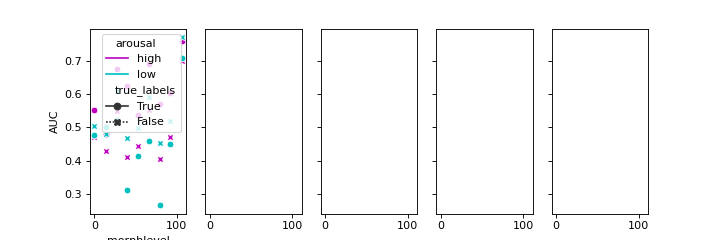

<AxesSubplot:xlabel='morphlevel', ylabel='AUC'>

In [476]:
fig, axn = pl.subplots(1,len(sizes), figsize=(9,3), sharex=True, sharey=True)

ax=axn[0]
aucr_ = auc_r[auc_r['size']==sz]

sns.lineplot(x='morphlevel', y='AUC', data=aucr_, ax=ax,
                hue='arousal', palette=arousal_colors,
                style='true_labels', style_order=[True, False], dashes=dashes, lw=0,
                markers=markers, sizes=[10,10])
    

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/pandas/core/computation/expressions.py:205: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


<IPython.core.display.Javascript object>


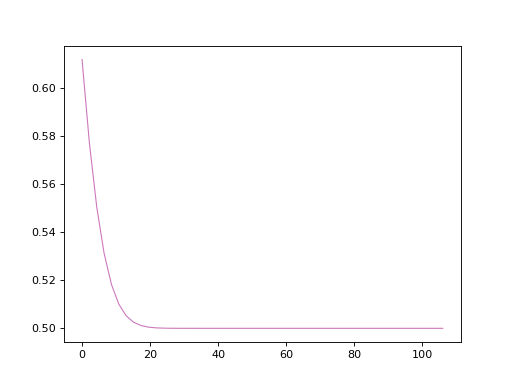

In [393]:
curr_fparams = fiter[(fiter.true_labels) * (fiter.arousal=='high') & (fiter['size']==30)]
fit, = curr_fparams[fit_params].values

# alpha = options['widthalpha']
# sigmoid = options['sigmoidName']
# PC = options['threshPC']       
sig='gauss'
opts = default_options()
opts['sigmoidName'] = 'neg_%s' % sig if eff==0 else sig
opts['sigmoidHandle'] = getSig.getSigmoidHandle(opts)
opts['widthalpha'] = .05

fig, ax= pl.subplots()

for lc, ar in zip()
plot_sigmoid_from_params(fit, opts, xmin=0, xmax=106, npoints=50, lc=lc,
                                lw=1, label=label, ax=ax)


In [204]:
arousal_colors={'high': 'm', 'low': 'c'}

sigmoid_ = 'gauss'

fig, axn = pl.subplots(1, 2, figsize=(10,4))

for (a_cond, curr_sz), a_ in auc_r[auc_r['size']==30].groupby(['arousal', 'size',]):
    ai = sizes.index(curr_sz)
    
    ax=axn[0]
    lc = mpl.colors.to_rgb( arousal_colors[a_cond] )
    
    data_ = data_matrix_from_auc(a_[a_.true_labels], param=param,normalize=True)
    opts = dict()
    opts['sigmoidName'] = 'neg_%s' % sigmoid_ if int(a_['Eff'].unique())==0 else sigmoid_
    opts['expType'] = '2AFC' #'2AFC'
    opts['threshPC'] = 0.5
    at_pc = 0.75 if opts['expType']=='2AFC' else 0.5
    res_ = ps.psignifit(data_, opts)

    thr = ps.getThreshold(res_, at_pc)[0] # Value at which function reaches at_pc correct
    slp = ps.getSlope(res_, ps.getThreshold(res_, at_pc)[0]) # Slope at given stimulus level
    info_str = '%s (thr=%.2f,slope=%.2f)' % (a_cond, thr, slp)
    ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=False, 
                                 lineColor=lc, label=info_str)
    
    ax=axn[1]
    data_ = data_matrix_from_auc(a_[~a_.true_labels], param=param,normalize=True)
    opts = dict()
    opts['sigmoidName'] = 'neg_%s' % sigmoid_ if int(a_['Eff'].unique())==0 else sigmoid_
    opts['expType'] = '2AFC' #'2AFC'
    opts['threshPC'] = 0.5
    at_pc = 0.75 if opts['expType']=='2AFC' else 0.5
    res_ = ps.psignifit(data_, opts)

    thr = ps.getThreshold(res_, at_pc)[0] # Value at which function reaches at_pc correct
    slp = ps.getSlope(res_, ps.getThreshold(res_, at_pc)[0]) # Slope at given stimulus level
    info_str = '%s (thr=%.2f,slope=%.2f)' % (a_cond, thr, slp)
    ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=False, 
                                 lineColor=lc, label=info_str)
    
    fig.text(0.01, 0.95, 'Sz %i (%s)' % (curr_sz, sigmoid_), fontsize=16)
    ax.legend()

array([2.26854062e+01, 3.62768755e+01, 1.15515243e-12, 5.00000000e-01,
       1.09553646e-10])

In [15]:
#### Load AUC 
sigmoid = 'gauss'
param='morphlevel'
allow_negative=True
class_a=0
class_b=106

AUC = load_aggregate_AUC(param=param, reverse_eff=not(allow_negative),
                          selective_only=False, selective_df=None)
    

   cell  level_1  index       AUC  morphlevel  size  n_trials  Eff  \
0    76        0     40  0.548889           0  10.0        30  106   
1    76        1      0  0.484444          14  10.0        30  106   
2    76        2      1  0.372222          27  10.0        30  106   
3    76        3      2  0.457778          40  10.0        30  106   
4    76        4      3  0.401111          53  10.0        30  106   

  visual_area              datakey  
0          Li  20190422_JC076_fov1  
1          Li  20190422_JC076_fov1  
2          Li  20190422_JC076_fov1  
3          Li  20190422_JC076_fov1  
4          Li  20190422_JC076_fov1  


In [16]:
criterion = 0.7

passAUC = AUC[(AUC['morphlevel'].isin([class_a, class_b])) & (AUC['AUC']>=criterion)].copy()


print("Total N cells fit:")
print(AUC[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())
print("N cells pass (crit=%.2f):" % criterion)
print(passAUC[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())



Total N cells fit:
             datakey  cell
visual_area               
Li               451   451
Lm              1061  1061
V1              1251  1251
N cells pass (crit=0.70):
             datakey  cell
visual_area               
Li               147   147
Lm               342   342
V1               553   553


In [17]:
print(selective_df[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


             datakey  cell
visual_area               
Li               326   326
Lm               636   636
V1               892   892


In [18]:
selective_only=False
selective_str = 'selective' if selective_only else "allcells"

if selective_only:
    print("... getting SELECTIVE only")
    s_=[]
    for (va, dk), g in passAUC.groupby(['visual_area', 'datakey']):
        curr_cells_auc = g['cell'].unique()

        curr_cells_sel = selective_df[(selective_df.visual_area==va) & (selective_df.datakey==dk)]['cell'].unique()
        sel_and_auc = np.intersect1d(curr_cells_auc, curr_cells_sel)
        s_.append(g[g['cell'].isin(sel_and_auc)])

    pSEL = pd.concat(s_, axis=0).reset_index(drop=True)

else:
    pSEL = passAUC.copy()
    
print(pSEL[['visual_area', 'datakey', 'cell']].drop_duplicates().groupby(['visual_area']).count())


             datakey  cell
visual_area               
Li               147   147
Lm               342   342
V1               553   553


In [19]:
ncells_pass = passAUC.groupby(['visual_area', 'datakey']).count()['cell'].reset_index()
# ncells_pass

In [20]:
del AUC

<IPython.core.display.Javascript object>


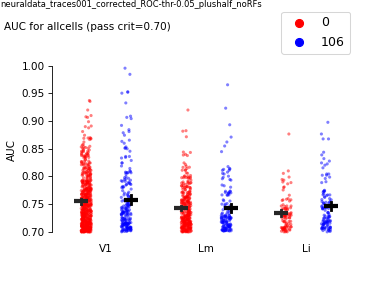

/n/coxfs01/julianarhee/aggregate-visual-areas/blobs-tuning/neurometric_curves/psignifit auc_allcells-crit-0.70


In [21]:
object_colors = {'A': 'r', 'B': 'b', 0:'r', 106: 'b'}
visual_areas=['V1', 'Lm', 'Li']
fig, ax = pl.subplots(figsize=(5,4), dpi=100)
sns.stripplot(x='visual_area', y='AUC', hue='Eff', data=pSEL, ax=ax, zorder=-1,
             dodge=0.5, palette=object_colors, alpha=0.5,size=3, order=visual_areas)

sns.pointplot(x='visual_area', y='AUC', hue='Eff', data=pSEL, ax=ax,
             join=False, dodge=0.5, color='k', markers='_', order=visual_areas,
             zorder=-1, scale=2)

ax.tick_params(which='both', axis='x', size=0)
sns.despine(trim=True, offset=4, bottom=True)
ax.set_xlabel('')

fig.text(0.01, 0.9, 'AUC for %s (pass crit=%.2f)' % (selective_str, criterion))

crop_legend_labels(ax, n_hues=2, bbox_to_anchor=(1,1), loc='lower right')

pl.subplots_adjust(left=0.15, right=0.95, bottom=0.2, top=0.8)
label_figure(fig, data_id)

figname = 'auc_%s-crit-%.2f' % (selective_str, criterion)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


# Split arousal trials

In [22]:
fit_cells = pass_estimates[['visual_area', 'datakey', 'cell', 'size']].drop_duplicates()
fit_cells[['visual_area', 'datakey', 'cell']].drop_duplicates()['visual_area'].value_counts()

NameError: name 'pass_estimates' is not defined

In [15]:
def decode_analysis_id(visual_area=None, prefix='split_pupil', response_type='dff', responsive_test='ROC',
                       overlap_str='noRF', trial_epoch='plushalf', C_str='tuneC'):
    
    results_id = '%s_%s__%s-%s_%s__%s__%s' \
                    % (prefix, visual_area, response_type, responsive_test, overlap_str, trial_epoch, C_str)
    return results_id


In [16]:
def add_morph_info(ndf, sdf, morph_lut, a_morphs, b_morphs, midp=53):
    # add stimulus info
    morphlevels = sdf['morphlevel'].unique()
    max_morph = max(morphlevels)

    assert midp in  morphlevels, "... Unknown midpoint in morphs: %s" % str(morphlevels)
        
    ndf['size'] = [sdf['size'][c] for c in ndf['config']]
    ndf['morphlevel'] = [sdf['morphlevel'][c] for c in ndf['config']]
    ndf = ndf[(ndf['morphlevel']!=-1)].copy()

    morph_lut, a_morphs, b_morphs = get_morph_levels(levels=morphlevels, midp=midp)
    # update neuraldata
    ndf['morphstep'] = [morph_lut[m] for m in ndf['morphlevel']]
    ndf['morph_ix'] = [m/float(max_morph) for m in ndf['morphlevel']]

    ndf['object'] = None
    ndf.loc[ndf.morphlevel.isin(a_morphs), 'object'] = 'A'
    ndf.loc[ndf.morphlevel.isin(b_morphs), 'object'] = 'B'
    ndf.loc[ndf.morphlevel==midp, 'object'] = 'M'

    return ndf

In [ ]:
decode_prefix='split_pupil'
morph_lut, a_morphs, b_morphs = get_morph_levels()

# 

#### Testing loading AUCs and fitting curve for 1 fov

In [35]:
decode_prefix='split_pupil'
morph_lut, a_morphs, b_morphs = get_morph_levels()

# 
va='V1'
dk='20190616_JC097_fov1'

sdf = SDF[dk].copy()

curr_results_id = decode_analysis_id(visual_area=va, responsive_test=responsive_test,
                       response_type='dff', overlap_str='noRF', trial_epoch='plushalf')
print(curr_results_id)

traceid_dir = get_tracedir_from_datakey(dk)
print(traceid_dir)

split_pupil_V1__dff-ROC_noRF__plushalf__tuneC
/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_d1a2cd_traces001_a13a76_traces001_0a4432_traces001_6fc2ca_traces001_2449cf_traces001_70650b


In [207]:
glob.glob(os.path.join(traceid_dir, 'neurometric', 'aucs'))

['/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_d1a2cd_traces001_a13a76_traces001_0a4432_traces001_6fc2ca_traces001_2449cf_traces001_70650b/neurometric/aucs']

In [41]:
#### tets loading
auc_outfile = glob.glob(os.path.join(traceid_dir, 'neurometric', 'aucs', '%s.pkl' % curr_results_id))[0]
with open(auc_outfile, 'rb') as f:
    auc_fov = pkl.load(f)
    

In [56]:
mean_ = auc_fov.groupby(['visual_area', 'datakey', 'cell', 
                         'arousal', 'true_labels', 'morphlevel', 'size']).mean().reset_index()

In [215]:
mean_[mean_['cell']==217]

visual_area              datakey  cell arousal  true_labels  morphlevel  \
17460          V1  20190616_JC097_fov1   217    high        False           0   
17461          V1  20190616_JC097_fov1   217    high        False           0   
17462          V1  20190616_JC097_fov1   217    high        False           0   
17463          V1  20190616_JC097_fov1   217    high        False           0   
17464          V1  20190616_JC097_fov1   217    high        False           0   
...           ...                  ...   ...     ...          ...         ...   
17635          V1  20190616_JC097_fov1   217     low         True         106   
17636          V1  20190616_JC097_fov1   217     low         True         106   
17637          V1  20190616_JC097_fov1   217     low         True         106   
17638          V1  20190616_JC097_fov1   217     low         True         106   
17639          V1  20190616_JC097_fov1   217     low         True         106   

       size  index       AUC  n_trials  Eff  iteration  n_chooseB  
17460  10.0    0.0  0.622000       5.0  0.0       49.5   3.110000  
17461  20.0    8.0  0.629375       8.0  0.0       49.5   5.035000  
17462  30.0   16.0  0.945952       7.0  0.0       49.5   6.621667  
17463  40.0   24.0  0.665500       5.0  0.0       49.5   3.327500  
17464  50.0   32.0  0.497857       7.0  0.0       49.5   3.485000  
...     ...    ...       ...       ...  ...        ...        ...  
17635  10.0   40.0  0.445000       5.0  0.0       49.5   2.225000  
17636  20.0   41.0  0.564063       8.0  0.0       49.5   4.512500  
17637  30.0   42.0  0.533889       7.0  0.0       49.5   3.737222  
17638  40.0   43.0  0.546250       5.0  0.0       49.5   2.731250  
17639  50.0   44.0  0.468333       7.0  0.0       49.5   3.278333  

[180 rows x 13 columns]

In [211]:
mean_.head()

visual_area              datakey  cell arousal  true_labels  morphlevel  \
0          V1  20190616_JC097_fov1     0    high        False           0   
1          V1  20190616_JC097_fov1     0    high        False           0   
2          V1  20190616_JC097_fov1     0    high        False           0   
3          V1  20190616_JC097_fov1     0    high        False           0   
4          V1  20190616_JC097_fov1     0    high        False           0   

   size  index       AUC  n_trials    Eff  iteration  n_chooseB  
0  10.0  17.20  0.507500       5.0  45.58       49.5   2.537500  
1  20.0  22.19  0.529687       8.0  45.58       49.5   4.237500  
2  30.0  27.18  0.633254       7.0  45.58       49.5   4.432778  
3  40.0  32.17  0.451250       5.0  45.58       49.5   2.256250  
4  50.0  37.16  0.520556       7.0  45.58       49.5   3.643889

In [212]:
len(mean_[mean_['AUC']>=0.7]['cell'].unique())

183

In [79]:
rid=217
auc_r = mean_[mean_['cell']==rid]

In [78]:
arousal_colors={'high': 'm', 'low': 'c'}


<IPython.core.display.Javascript object>


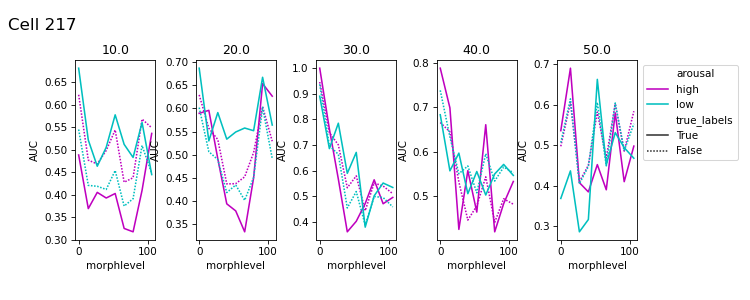

In [69]:
dashes=['', (1, 1)]
        
sizes = sorted(auc_r['size'].unique())

fig, axn = pl.subplots(1,len(sizes), figsize=(10,4))
for ax, (sz, sg) in zip(axn.flat, auc_r.groupby(['size'])):
    sns.lineplot(x='morphlevel', y='AUC', hue='arousal', data=sg, ax=ax,
                style_order=[True, False], dashes=dashes, style='true_labels', palette=arousal_colors)
    ax.legend_.remove()
    ax.set_title(sz)
    
axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left')
fig.text(0.01, 0.9, 'Cell %i' % rid, fontsize=16)
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5)

In [184]:
auc_fov.head()

cell  index  AUC  morphlevel  size  n_trials  Eff arousal  iteration  \
0     0     40 -0.0           0  10.0         5  106    high         91   
1     0      0  0.2          14  10.0         5  106    high         91   
2     0      1  0.7          27  10.0         5  106    high         91   
3     0      2  0.5          40  10.0         5  106    high         91   
4     0      3  0.6          53  10.0         5  106    high         91   

   true_labels  n_chooseB visual_area              datakey  
0        False       -0.0          V1  20190616_JC097_fov1  
1        False        1.0          V1  20190616_JC097_fov1  
2        False        3.5          V1  20190616_JC097_fov1  
3        False        2.5          V1  20190616_JC097_fov1  
4        False        3.0          V1  20190616_JC097_fov1

In [ ]:
auc_fov

In [80]:
auc_iters = auc_fov[(auc_fov['cell']==rid) & (auc_fov['size']==30)].copy()
auc_iters.head()

cell  index       AUC  morphlevel  size  n_trials  Eff arousal  \
4383   217     16  1.000000           0  30.0         7    0    high   
4384   217     17  0.785714          14  30.0         7    0    high   
4385   217     18  0.761905          27  30.0         7    0    high   
4386   217     19  0.583333          40  30.0         6    0    high   
4387   217     20  0.833333          53  30.0         7    0    high   

      iteration  true_labels  n_chooseB visual_area              datakey  
4383         91        False   7.000000          V1  20190616_JC097_fov1  
4384         91        False   5.500000          V1  20190616_JC097_fov1  
4385         91        False   5.333333          V1  20190616_JC097_fov1  
4386         91        False   3.500000          V1  20190616_JC097_fov1  
4387         91        False   5.833333          V1  20190616_JC097_fov1

In [130]:
def group_fit_psignifit(auc_, opts, ni=0, sig='gauss', 
                    param='morphlevel', allow_negative=True):
    '''
    auc_ is curve for 1 cell, 1 size (and 1 arousal state, 1 shuffle cond)
    '''
    param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
    at_pc = 0.75 if opts['expType']=='2AFC' else 0.5

    if allow_negative:
        opts['sigmoidName'] = 'neg_%s' % sig if int(auc_['Eff'].unique())==0 else sig
        # print(opts['sigmoidName'])

    data_ = data_matrix_from_auc(auc_, param=param, normalize=False)        
    res_ = ps.psignifit(data_, opts)
    try:
        thr = ps.getThreshold(res_, at_pc)[0] # Value at which function reaches at_pc correct
        slp = ps.getSlope(res_, ps.getThreshold(res_, at_pc)[0]) # Slope at given stimulus level
    except Exception as e:
        thr=None
        slp=None
        
    df_ = pd.DataFrame(res_['Fit'], index=param_names, columns=[ni]).T        
    df_['slope'] = slp
    df_['thr'] = thr
    
    add_cols= ['visual_area', 'datakey', 'cell', 'size', 'Eff']
    if  'arousal' in auc_.columns:
        add_cols.extend([ 'arousal', 'true_labels'])
    
    add_ = auc_[add_cols].drop_duplicates()
    add_.index = df_.index
    df_[add_cols] = add_

    return df_



In [192]:
cells= auc_fov['cell'].unique()[0:5]
cells[0:20]

array([ 0,  1,  2,  9, 11])

In [214]:
auc_fov[(auc_fov['cell']==217)]['eff'].unique()

KeyError: 'eff'

In [205]:
auc_iter = auc_fov[(auc_fov['cell']==217) & (auc_fov['iteration']<=5)]
ac = auc_iter.groupby(['cell', 'size', 'arousal', 'true_labels'], as_index=False).apply(fit_psignifit, opts)


In [204]:
group_cols = ['visual_area', 'datakey', 'cell', 'size']
group_cols.extend(['arousal', 'true_labels'])

sig = 'gauss'
opts = dict()
opts['sigmoidName'] = sig
opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
ex_ = mean_[ (mean_['cell'].isin([11, 217]))].copy()

d = ex_.groupby(['cell', 'size', 'arousal', 'true_labels'], as_index=False).apply(fit_psignifit, opts)


(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

<IPython.core.display.Javascript object>


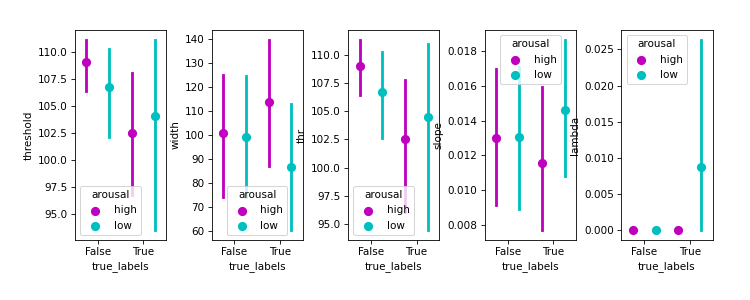

In [202]:
plot_pars =  ['threshold', 'width', 'thr', 'slope', 'lambda']
fig, axn = pl.subplots(1, len(plot_pars), figsize=(10,4))

plotd = d.dropna()

for ax, p in zip(axn.flat, plot_pars):
    #sns.stripplot(x='true_labels', y=p, hue='arousal', data=d, ax=ax, dodge=True, palette=arousal_colors)
    sns.pointplot(x='true_labels', y=p, hue='arousal', data=plotd, ax=ax, dodge=0.5, join=False,
                 palette=arousal_colors)
    
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.9, wspace=0.5)


In [104]:
add_

visual_area              datakey  cell  size
17552          V1  20190616_JC097_fov1   217  30.0

In [106]:
add_.index = [rid]
pd.concat([add_, df_], axis=1)

threshold     width        lambda  gamma       eta     slope       thr  \
217   0.180492  0.412307  1.115858e-07    0.5  0.000043 -1.591538  0.180492   

    visual_area              datakey  cell  size  
217          V1  20190616_JC097_fov1   217  30.0

<IPython.core.display.Javascript object>


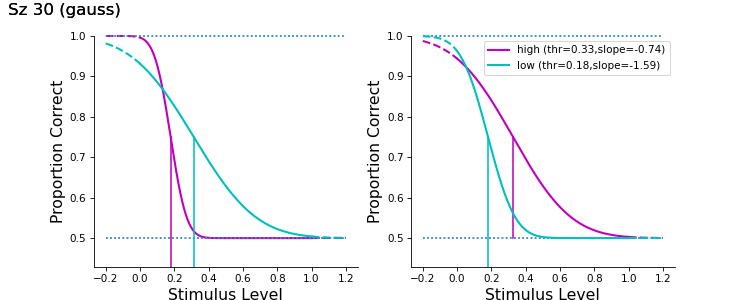

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [77]:
arousal_colors={'high': 'm', 'low': 'c'}

sigmoid_ = 'gauss'

fig, axn = pl.subplots(1, 2, figsize=(10,4))

for (a_cond, curr_sz), a_ in auc_r[auc_r['size']==30].groupby(['arousal', 'size',]):
    ai = sizes.index(curr_sz)
    
    ax=axn[0]
    lc = mpl.colors.to_rgb( arousal_colors[a_cond] )
    
    data_ = data_matrix_from_auc(a_[a_.true_labels], param=param,normalize=True)
    opts = dict()
    opts['sigmoidName'] = 'neg_%s' % sigmoid_ if int(a_['Eff'].unique())==0 else sigmoid_
    opts['expType'] = '2AFC' #'2AFC'
    opts['threshPC'] = 0.5
    at_pc = 0.75 if opts['expType']=='2AFC' else 0.5
    res_ = ps.psignifit(data_, opts)

    thr = ps.getThreshold(res_, at_pc)[0] # Value at which function reaches at_pc correct
    slp = ps.getSlope(res_, ps.getThreshold(res_, at_pc)[0]) # Slope at given stimulus level
    info_str = '%s (thr=%.2f,slope=%.2f)' % (a_cond, thr, slp)
    ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=False, 
                                 lineColor=lc, label=info_str)
    
    ax=axn[1]
    data_ = data_matrix_from_auc(a_[~a_.true_labels], param=param,normalize=True)
    opts = dict()
    opts['sigmoidName'] = 'neg_%s' % sigmoid_ if int(a_['Eff'].unique())==0 else sigmoid_
    opts['expType'] = '2AFC' #'2AFC'
    opts['threshPC'] = 0.5
    at_pc = 0.75 if opts['expType']=='2AFC' else 0.5
    res_ = ps.psignifit(data_, opts)

    thr = ps.getThreshold(res_, at_pc)[0] # Value at which function reaches at_pc correct
    slp = ps.getSlope(res_, ps.getThreshold(res_, at_pc)[0]) # Slope at given stimulus level
    info_str = '%s (thr=%.2f,slope=%.2f)' % (a_cond, thr, slp)
    ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=False, 
                                 lineColor=lc, label=info_str)
    
    fig.text(0.01, 0.95, 'Sz %i (%s)' % (curr_sz, sigmoid_), fontsize=16)
    ax.legend()

<IPython.core.display.Javascript object>


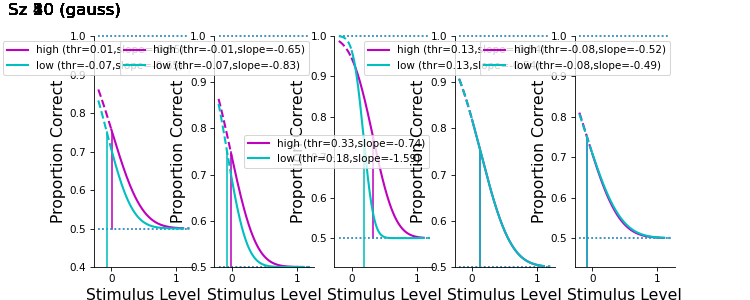

(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[0.01 1.19 0.   0.5  0.  ]
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[-0.01  1.01  0.    0.5   0.  ]
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[0.33 0.88 0.   0.5  0.  ]
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[0.13 1.21 0.   0.5  0.  ]
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[-0.08  1.27  0.    0.5   0.  ]
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[-0.07  1.01  0.    0.5   0.  ]
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[-0.07  0.79  0.    0.5   0.  ]
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[0.18 0.41 0.   0.5  0.  ]
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[0.13 1.21 0.   0.5  0.  ]
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[-0.08  1.33  0.    0.5   0.  ]


In [76]:


#curr_sz=30
#a_ = auc_r[auc_r['size']==curr_sz].copy() #auc_r.groupby(['size'])

fig, axn = pl.subplots(1, len(sizes), figsize=(10,4))

for (a_cond, curr_sz), a_ in auc_r[~auc_r.true_labels].groupby(['arousal', 'size',]):
    ai = sizes.index(curr_sz)
    ax=axn[ai]
    lc = mpl.colors.to_rgb( arousal_colors[a_cond] )
    
    data_ = data_matrix_from_auc(a_, param=param,normalize=True)
    opts = dict()
    opts['sigmoidName'] = 'neg_%s' % sigmoid_ if int(a_['Eff'].unique())==0 else sigmoid_

    opts['expType'] = '2AFC' #'2AFC'
    opts['threshPC'] = 0.5
    at_pc = 0.75 if opts['expType']=='2AFC' else 0.5
    res_ = ps.psignifit(data_, opts)
    print(res_['Fit'].round(2))

    thr = ps.getThreshold(res_, at_pc)[0] # Value at which function reaches at_pc correct
    slp = ps.getSlope(res_, ps.getThreshold(res_, at_pc)[0]) # Slope at given stimulus level

    info_str = '%s (thr=%.2f,slope=%.2f)' % (a_cond, thr, slp)

    ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=False, 
                                 lineColor=lc, label=info_str)
    fig.text(0.01, 0.95, 'Sz %i (%s)' % (curr_sz, sigmoid_), fontsize=16)
    ax.legend()

# test 1 cell/fov

## Load split trial input data

In [43]:

decoding_outfile = os.path.join(traceid_dir, 'decoding', 'inputdata_%s.pkl' % curr_results_id)
assert os.path.exists(decoding_outfile),\
        "(%s, %s) No <%s> results: %s" % (dk, va, decode_prefix, curr_results_id)

with open(decoding_outfile, 'rb') as f:
    indata = pkl.load(f, encoding='latin1')
trialdf = indata['input_trials']

NameError: name 'curr_results_id' is not defined

In [42]:
curr_trials = trialdf[trialdf.true_labels].sort_values(by=['iteration', 'arousal'])

NameError: name 'trialdf' is not defined

In [322]:
curr_trials[(curr_trials['iteration']==0) & (curr_trials['arousal']=='high')]


trial  iteration arousal  true_labels
0    1031.0          0    high         True
1     580.0          0    high         True
2    1129.0          0    high         True
3     508.0          0    high         True
4    1052.0          0    high         True
..      ...        ...     ...          ...
308  1303.0          0    high         True
309   356.0          0    high         True
310   573.0          0    high         True
311   336.0          0    high         True
312   502.0          0    high         True

[313 rows x 4 columns]

In [271]:
curr_cells = fit_cells[(fit_cells.visual_area==va) & (fit_cells.datakey==dk)]['cell'].unique()
ndf = DATA[(DATA.visual_area==va) & (DATA.datakey==dk) & (DATA.cell.isin(curr_cells))].copy()
ndf = add_morph_info(ndf, sdf, morph_lut, a_morphs, b_morphs)
    

In [352]:
a_=[]
for (ni, a_cond), a_df in curr_trials.groupby(['iteration', 'arousal']):
    auc_ = ndf[ndf['trial'].isin(a_df['trial'].values)]\
            .groupby('cell').apply(get_auc_AB, param=param, reverse_eff=False).reset_index().drop('level_1', axis=1)
    auc_['arousal'] = a_cond
    auc_['iteration'] = ni
    a_.append(auc_)
split_auc = pd.concat(a_).reset_index(drop=True)
split_auc['n_chooseB'] = split_auc['AUC']*split_auc['n_trials']


KeyboardInterrupt: 

In [358]:
mean_auc = pd.concat(a_).reset_index(drop=True).groupby(['cell', 'morphlevel', 'size', 'arousal', 'iteration']).mean().reset_index()

In [59]:
param='morphlevel'

class WorkerStop(Exception):
    pass

def get_morph_levels(midp=53, levels=[-1, 0, 14, 27, 40, 53, 66, 79, 92, 106]):

    a_morphs = np.array(sorted([m for m in levels if m<midp and m!=-1]))[::-1]
    b_morphs = np.array(sorted([m for m in levels if m>midp and m!=-1]))

    d1 = dict((k, list(a_morphs).index(k)+1) for k in a_morphs)
    d2 = dict((k, list(b_morphs).index(k)+1) for k in b_morphs)
    morph_lut = d1.copy()
    morph_lut.update(d2)
    morph_lut.update({midp: 0, -1: -1})

    return morph_lut, a_morphs, b_morphs
def auc_split_pupil_worker(out_q, iternums, ndf, trialdf, param):

    i_list = []
    for ni in iternums:
        ith_ixs = trialdf[trialdf['iteration']==ni]
        for (arousal_label, shuffle_cond), a_df in curr_trials.groupby(['arousal', 'true_labels']):
            try:
                curr_auc = ndf[ndf['trial'].isin(a_df['trial'].values)]\
                                .groupby('cell').apply(get_auc_AB, param=param, reverse_eff=False).reset_index().drop('level_1', axis=1)
                curr_auc['arousal'] = a_cond
                curr_auc['iteration'] = ni
                curr_auc['true_labels'] = shuffle_cond
                curr_auc['n_chooseB'] = curr_auc['AUC']*curr_auc['n_trials']

                i_list.append(curr_auc)
            except Exception as e:
                out_q.put(None)
                raise WorkerStop("error!")
                
        curr_iterdf = pd.concat(i_list, axis=0)

    out_q.put(curr_iterdf)
    
    
    
def iterate_auc_split_pupil(ndf, trialdf, n_iteration=100, param='morphlevel'):
    iterdf=None
    
    results = []
    terminating = mp.Event()
    try:
        iter_list = np.arange(0, n_iterations)
        out_q = mp.Queue()
        chunksize = int(math.ceil(len(iter_list) / float(n_processes)))

        procs = []
        for i in range(n_processes):
            p = mp.Process(target=auc_split_pupil_worker, 
                           args=(out_q, iter_list[chunksize * i:chunksize * (i + 1)],
                                 ndf, trialdf, param))
            iternums
            p.start()
        results=[]
        for i in range(n_processes):
            res = out_q.get(99999)
            results.append(res)
        for p in procs:
            p.join()
    except WorkerStop:
        print("No results (terminating)")
        terminating.set()
    except KeyboardInterrupt:
        terminating.set()
    except Exception as e:
        traceback.print_exc()
    finally:
        for p in procs:
            p.join()
            print('%s.exitcode = %s' % (p.name, p.exitcode))

    res_ = [i for i in results if i is not None]
    if len(res_)>0:
        iterdf = pd.concat(res_,axis=0)

    return iterdf


def calculate_auc_split_pupil(va, dk, ndf, sdf, trialdf, decode_id='results_id', param='morphlevel'):
    traceid_dir = get_tracedir_from_datakey(dk)
    
    # Setup output file
    results_outfile = os.path.join(traceid_dir, 'neurometric', 'aucs', '%s.pkl' % (decode_id))
    if os.path.exists(results_outfile):
        os.remove(outfile)
    
    # Get source trials
    decoding_outfile = os.path.join(traceid_dir, 'decoding', 'inputdata_%s.pkl' % decode_id)
    assert os.path.exists(decoding_outfile),\
            "(%s, %s) No split_pupil results: %s" % (dk, va, decode_id)

    with open(decoding_outfile, 'rb') as f:
        indata = pkl.load(f, encoding='latin1')
    trialdf = indata['input_trials']
    n_iterations = trialdf['iteration'].max()+1
    print("~~~~~~~~~~ N iterations=%i" % n_iterations)
    
    iterdf = iterate_auc_split_pupil(ndf, trialdf, n_iteration=n_iterations, param=param)
    
    if iterdf is None:
        print("None returned -- %s, %s" % (va, dk))
        return None
    
    iterdf['visual_area'] = va
    iterdf['datakey'] = dk
    
    print("@@@@@@@@@ done. %s|%s  @@@@@@@@@@" % (va, dk))  
    print(results_outfile)
    
    return


def add_morph_info(ndf, sdf, morph_lut, a_morphs, b_morphs, midp=53):
    # add stimulus info
    morphlevels = sdf['morphlevel'].unique()
    max_morph = max(morphlevels)

    assert midp in  morphlevels, "... Unknown midpoint in morphs: %s" % str(morphlevels)
        
    ndf['size'] = [sdf['size'][c] for c in ndf['config']]
    ndf['morphlevel'] = [sdf['morphlevel'][c] for c in ndf['config']]
    ndf0=ndf.copy()
    ndf = ndf0[ndf0['morphlevel']!=-1].copy()

    morph_lut, a_morphs, b_morphs = get_morph_levels(levels=morphlevels, midp=midp)
    # update neuraldata
    ndf['morphstep'] = [morph_lut[m] for m in ndf['morphlevel']]
    ndf['morph_ix'] = [m/float(max_morph) for m in ndf['morphlevel']]

    ndf['object'] = None
    ndf.loc[ndf.morphlevel.isin(a_morphs), 'object'] = 'A'
    ndf.loc[ndf.morphlevel.isin(b_morphs), 'object'] = 'B'
    ndf.loc[ndf.morphlevel==midp, 'object'] = 'M'

    return ndf

def decode_analysis_id(visual_area=None, prefix='split_pupil', response_type='dff', responsive_test='ROC',
                       overlap_str='noRF', trial_epoch='plushalf', C_str='tuneC'):
    
    results_id = '%s_%s__%s-%s_%s__%s__%s' \
                    % (prefix, visual_area, response_type, responsive_test, overlap_str, trial_epoch, C_str)
    return results_id


def calculate_auc(p_hits, p_fas, resp_cfgs1): #, reverse_eff=False, Eff=None):
    if p_fas.shape[0] < p_hits.shape[0]:
        altconds = list(np.unique([c[0] for c in resp_cfgs1]))
        true_auc = [-np.trapz(p_hits[ci, :], x=p_fas[altconds.index(sz), :]) \
                            for ci, (sz, mp) in enumerate(resp_cfgs1)]
    else:
        true_auc = [-np.trapz(p_hits[ci, :], x=p_fas[ci, :]) for ci in np.arange(0, len(resp_cfgs1))]
        
    aucs = pd.DataFrame({'AUC': true_auc, 
                          param: [r[1] for r in resp_cfgs1], 
                         'size': [r[0] for r in resp_cfgs1]}) 
#    if reverse_eff and Eff==0:
#        # flip
#        for sz, a in aucs.groupby(['size']):
#            aucs.loc[a.index, 'AUC'] = a['AUC'].values[::-1]
#        
    return aucs


def get_auc_AB(rdf, param='morphlevel', n_crit=50, include_ref=True, allow_negative=True,
                  class_a=0, class_b=106, return_probs=False):
    '''
    Calculate AUCs for A vs. B at each size. 
    Note:  rdf must contain columns 'morphstep' and 'size' (morphstep LUT from: get_morph_levels())

    include_ref: include morphlevel=0 (or morph_ixx) by splitting into half.
    Compare p_hit (morph=0) to p_fa (morph=106), calculate AUC.
    '''
    # Get Eff/Ineff
    means = rdf[rdf.morphlevel.isin([class_a, class_b])].groupby(['object']).mean()
    Eff = class_a if means['response']['A'] > means['response']['B'] else class_b

    p_hits, p_fas, resp_cfgs, counts = split_signal_distns(rdf, param=param, n_crit=n_crit, 
                                                        include_ref=include_ref, Eff=Eff)
        
    aucs =  calculate_auc(p_hits, p_fas, resp_cfgs)#, 
#                             reverse_eff=not(allow_negative)) #, Eff=Eff)
    aucs['Eff'] = None
    for sz, ac in aucs.groupby(['size']):
        means = rdf[(rdf['size']==sz) & (rdf.morphlevel.isin([class_a, class_b]))].groupby(['object']).mean()
        Eff = class_a if means['response']['A'] > means['response']['B'] else class_b
        aucs.loc[ac.index, 'Eff']=Eff
        if Eff==0 and allow_negative is False:
            # flip
            aucs.loc[ac.index, 'AUC'] = ac['AUC'].values[::-1]
           
    aucs['n_trials'] = counts
    # aucs['Eff'] = Eff
    
    if return_probs:
        return aucs, p_hits, p_fas, resp_cfgs
    else:
        return aucs.sort_values(by=['size', 'morphlevel']).reset_index()


In [53]:
va='V1'
dk='20190616_JC097_fov1'

dst_dir = os.path.join(traceid_dir, 'neurometric', 'aucs')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

    
sdf = SDF[dk].copy()


morph_lut, a_morphs, b_morphs = get_morph_levels()

ndf = DATA[(DATA.visual_area==va) & (DATA.datakey==dk)].copy()
ndf = add_morph_info(ndf, sdf, morph_lut, a_morphs, b_morphs)
    

curr_results_id = decode_analysis_id(visual_area=va, responsive_test=responsive_test,
                       response_type='dff', overlap_str='noRF', trial_epoch='plushalf')

print(curr_results_id)

traceid_dir = get_tracedir_from_datakey(dk)
dst_dir = os.path.join(traceid_dir, 'neurometric', 'aucs')
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)


decoding_outfile = os.path.join(traceid_dir, 'decoding', 'inputdata_%s.pkl' % curr_results_id)
assert os.path.exists(decoding_outfile),\
        "(%s, %s) No <%s> results: %s" % (dk, va, decode_prefix, results_id)

with open(decoding_outfile, 'rb') as f:
    indata = pkl.load(f, encoding='latin1')
trialdf = indata['input_trials']


split_pupil_V1__dff-ROC_noRF__plushalf__tuneC


In [55]:
ni = 0
curr_trials = trialdf[trialdf['iteration']==ni]

In [57]:
for (arousal_label, shuffle_cond), a_df in curr_trials.groupby(['arousal', 'true_labels']):
    a_df.shape

In [63]:
ac = auc_fov_iters[(auc_fov_iters['visual_area']==va) & (auc_fov_iters.datakey==dk) 
             & (auc_fov_iters.arousal==arousal_label) & (auc_fov_iters.true_labels==shuffle_cond)
             & (auc_fov_iters['iteration']==ni)]

In [65]:
ac[ac['cell']==217]

cell  index       AUC  morphlevel  size  n_trials  Eff arousal  \
4365   217      0  0.550000           0  10.0         5    0     low   
4366   217      1  0.400000          14  10.0         5    0     low   
4367   217      2  0.350000          27  10.0         5    0     low   
4368   217      3  0.300000          40  10.0         5    0     low   
4369   217      4  0.600000          53  10.0         5    0     low   
4370   217      5  0.400000          66  10.0         5    0     low   
4371   217      6  0.500000          79  10.0         5    0     low   
4372   217      7  0.550000          92  10.0         5    0     low   
4373   217     40  0.375000         106  10.0         5    0     low   
4374   217      8  0.734375           0  20.0         8    0     low   
4375   217      9  0.515625          14  20.0         8    0     low   
4376   217     10  0.589286          27  20.0         7    0     low   
4377   217     11  0.453125          40  20.0         8    0     low   
4378   217     12  0.593750          53  20.0         8    0     low   
4379   217     13  0.562500          66  20.0         8    0     low   
4380   217     14  0.593750          79  20.0         8    0     low   
4381   217     15  0.718750          92  20.0         8    0     low   
4382   217     41  0.750000         106  20.0         8    0     low   
4383   217     16  0.976190           0  30.0         7    0     low   
4384   217     17  0.833333          14  30.0         7    0     low   
4385   217     18  0.952381          27  30.0         7    0     low   
4386   217     19  0.571429          40  30.0         7    0     low   
4387   217     20  0.809524          53  30.0         7    0     low   
4388   217     21  0.428571          66  30.0         7    0     low   
4389   217     22  0.666667          79  30.0         7    0     low   
4390   217     23  0.761905          92  30.0         7    0     low   
4391   217     42  0.888889         106  30.0         7    0     low   
4392   217     24  0.800000           0  40.0         5    0     low   
4393   217     25  0.750000          14  40.0         5    0     low   
4394   217     26  0.650000          27  40.0         5    0     low   
4395   217     27  0.400000          40  40.0         5    0     low   
4396   217     28  0.550000          53  40.0         5    0     low   
4397   217     29  0.500000          66  40.0         5    0     low   
4398   217     30  0.700000          79  40.0         5    0     low   
4399   217     31  0.700000          92  40.0         5    0     low   
4400   217     43  0.750000         106  40.0         5    0     low   
4401   217     32  0.428571           0  50.0         7    0     low   
4402   217     33  0.333333          14  50.0         7    0     low   
4403   217     34  0.214286          27  50.0         7    0     low   
4404   217     35  0.266667          40  50.0         5    0     low   
4405   217     36  0.642857          53  50.0         7    0     low   
4406   217     37  0.428571          66  50.0         7    0     low   
4407   217     38  0.500000          79  50.0         7    0     low   
4408   217     39  0.428571          92  50.0         7    0     low   
4409   217     44  0.500000         106  50.0         7    0     low   

      iteration  true_labels  n_chooseB visual_area              datakey  
4365          0         True   2.750000          V1  20190616_JC097_fov1  
4366          0         True   2.000000          V1  20190616_JC097_fov1  
4367          0         True   1.750000          V1  20190616_JC097_fov1  
4368          0         True   1.500000          V1  20190616_JC097_fov1  
4369          0         True   3.000000          V1  20190616_JC097_fov1  
4370          0         True   2.000000          V1  20190616_JC097_fov1  
4371          0         True   2.500000          V1  20190616_JC097_fov1  
4372          0         True   2.750000          V1  20190616_JC097_fov1  
4373          0   

In [359]:
rid = 217

auc_r = mean_auc[mean_auc['cell']==rid].copy().reset_index(drop=True)
auc_r['n_chooseB'] = auc_r['AUC']*auc_r['n_trials']


In [360]:
auc_r.dtypes

cell            int64
morphlevel      int64
size          float64
arousal        object
iteration       int64
AUC           float64
n_trials        int64
Eff             int64
n_chooseB     float64
dtype: object

            trial     response     baseline     size  morphlevel  morphstep  \
object                                                                        
A       666.90625  1177.519314  1053.120576  30.3125         0.0        4.0   
B       693.53125  1120.601193  1072.330808  30.3125       106.0        4.0   

        morph_ix  
object            
A            0.0  
B            1.0  
(45, 50) (5, 50) 45


<IPython.core.display.Javascript object>


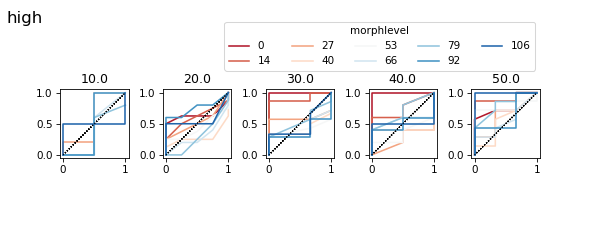

            trial     response    baseline     size  morphlevel  morphstep  \
object                                                                       
A       861.28125  1134.037619  1050.25437  30.3125         0.0        4.0   
B       863.18750  1096.068005  1062.43037  30.3125       106.0        4.0   

        morph_ix  
object            
A            0.0  
B            1.0  
(45, 50) (5, 50) 45


<IPython.core.display.Javascript object>


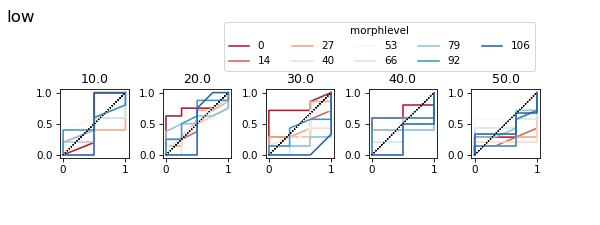

In [284]:
# a_cond='high'
# a_df = curr_trials[(curr_trials['iteration']==0) & (curr_trials.arousal==a_cond)].copy()

for a_cond, a_df in curr_trials[(curr_trials['iteration']==0)].groupby(['arousal']):
    curr_rdf = ndf[ndf['trial'].isin(a_df['trial'].values) & (ndf['cell']==rid)].copy()

    fig = plot_auc_for_cell(curr_rdf, param='morphlevel', class_a=0, class_b=106, cmap='RdBu')
    fig.text(0.01, 0.9, a_cond, fontsize=16)

In [364]:
auc_r

cell  morphlevel  size arousal  iteration       AUC  n_trials  Eff  \
0       217           0  10.0    high          0  0.000000         5    0   
1       217           0  10.0    high          1  0.500000         5    0   
2       217           0  10.0    high          2  0.450000         5    0   
3       217           0  10.0    high          3  0.550000         5    0   
4       217           0  10.0    high          4  1.000000         5    0   
...     ...         ...   ...     ...        ...       ...       ...  ...   
18355   217         106  50.0     low        199  0.444444         7    0   
18356   217         106  50.0     low        200  0.833333         7    0   
18357   217         106  50.0     low        201  0.444444         7    0   
18358   217         106  50.0     low        202  0.444444         7    0   
18359   217         106  50.0     low        203  0.888889         7    0   

       n_chooseB  
0       0.000000  
1       2.500000  
2       2.250000  
3       2.750000  
4       5.000000  
...          ...  
18355   3.111111  
18356   5.833333  
18357   3.111111  
18358   3.111111  
18359   6.222222  

[18360 rows x 9 columns]

<IPython.core.display.Javascript object>


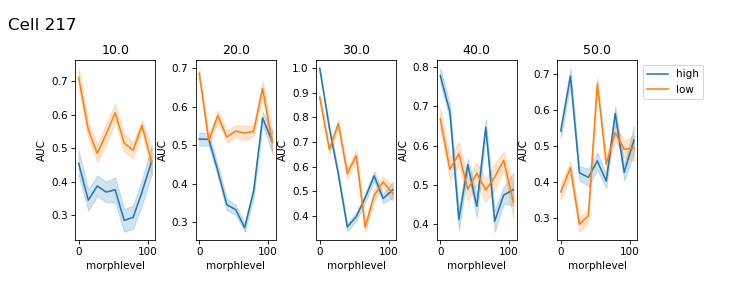

In [366]:
fig, axn = pl.subplots(1,len(sizes), figsize=(10,4))
for ax, (sz, sg) in zip(axn.flat, auc_r.groupby(['size'])):
    sns.lineplot(x='morphlevel', y='AUC', hue='arousal', data=sg, ax=ax)
    ax.legend_.remove()
    ax.set_title(sz)
    
axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left')
fig.text(0.01, 0.9, 'Cell %i' % rid, fontsize=16)
pl.subplots_adjust(left=0.1, right=0.85, bottom=0.2, top=0.8, wspace=0.5)

In [335]:
ts = curr_trials[(curr_trials['iteration']==0) & (curr_trials['arousal']=='high')]['trial'].values

ndf[(ndf['trial'].isin(ts)) & (ndf['cell']==rid)].sort_values(by='config').groupby(['config']).count()

datakey  trial  visual_area  cell  response  baseline  size  \
config                                                                   
config006        5      5            5     5         5         5     5   
config007        8      8            8     8         8         8     8   
config008        7      7            7     7         7         7     7   
config009        5      5            5     5         5         5     5   
config010        7      7            7     7         7         7     7   
config011        5      5            5     5         5         5     5   
config012        8      8            8     8         8         8     8   
config013        7      7            7     7         7         7     7   
config014        5      5            5     5         5         5     5   
config015        7      7            7     7         7         7     7   
config016        5      5            5     5         5         5     5   
config017        8      8            8     8         8         8     8   
config018        7      7            7     7         7         7     7   
config019        5      5            5     5         5         5     5   
config020        7      7            7     7         7         7     7   
config021        5      5            5     5         5         5     5   
config022        8      8            8     8         8         8     8   
config023        6      6            6     6         6         6     6   
config024        5      5            5     5         5         5     5   
config025        7      7            7     7         7         7     7   
config026        5      5            5     5         5         5     5   
config027        8      8            8     8         8         8     8   
config028        7      7            7     7         7         7     7   
config029        5      5            5     5         5         5     5   
config030        7      7            7     7         7         7     7   
config031        5      5            5     5         5         5     5   
config032        5      5            5     5         5         5     5   
config033        7      7            7     7         7         7     7   
config034        5      5            5     5         5         5     5   
config035        7      7            7     7         7         7     7   
config036        5      5            5     5         5         5     5   
config037        8      8            8     8         8         8     8   
config038        7      7            7     7         7         7     7   
config039        5      5            5     5         5         5     5   
config040        7      7            7     7         7         7     7   
config041        5      5            5     5         5         5     5   
config042        5      5            5     5         5         5     5   
config043        7      7            7     7         7         7     7   
config044        5      5            5     5         5         5     5   
config045        7      7            7     7         7         7     7   
config046        5      5            5     5         5         5     5   
config047        8      8            8     8         8         8     8   
config048        7      7            7     7         7         7     7   
config049        5      5            5     5         5         5     5   
config050        7      7            7     7         7         7     7   

           morphlevel  morphstep  morph_ix  object  
config                                              
config006           5          5         5       5  
config007           8          8         8       8  
config008           7          7         7       7  
config009           5          5         5       5  
config010           7          7         7       7  
config011           5          5         5       5  
config012           8          8         8       8  
config013           7          7         7       7  
co

In [362]:
auc_r.head()

cell  morphlevel  size arousal  iteration   AUC  n_trials  Eff  n_chooseB
0   217           0  10.0    high          0  0.00         5    0       0.00
1   217           0  10.0    high          1  0.50         5    0       2.50
2   217           0  10.0    high          2  0.45         5    0       2.25
3   217           0  10.0    high          3  0.55         5    0       2.75
4   217           0  10.0    high          4  1.00         5    0       5.00

<IPython.core.display.Javascript object>


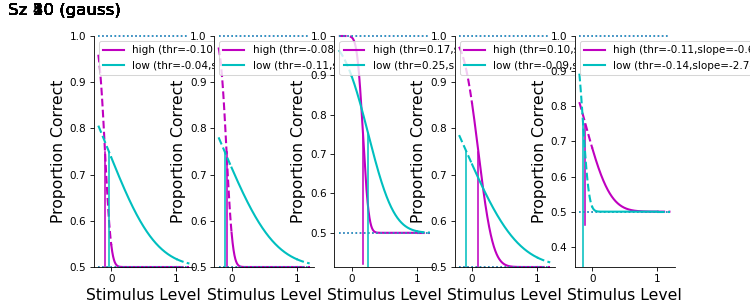

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:237: UserWarning: psignifit:pooling
We pooled your data, to avoid problems with n=1 blocks or to save time fitting because you have a lot of blocks
You can force acceptance of your blocks by increasing options.nblocks
  warnings.warn('psignifit:pooling\n'\


(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:237: UserWarning: psignifit:pooling
We pooled your data, to avoid problems with n=1 blocks or to save time fitting because you have a lot of blocks
You can force acceptance of your blocks by increasing options.nblocks
  warnings.warn('psignifit:pooling\n'\


[-0.1   0.24  0.    0.5   0.15]
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:237: UserWarning: psignifit:pooling
We pooled your data, to avoid problems with n=1 blocks or to save time fitting because you have a lot of blocks
You can force acceptance of your blocks by increasing options.nblocks
  warnings.warn('psignifit:pooling\n'\


[-0.08  0.24  0.    0.5   0.17]
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[0.17 0.23 0.   0.5  0.13]
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:237: UserWarning: psignifit:pooling
We pooled your data, to avoid problems with n=1 blocks or to save time fitting because you have a lot of blocks
You can force acceptance of your blocks by increasing options.nblocks
  warnings.warn('psignifit:pooling\n'\
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[0.1  0.58 0.   0.5  0.17]
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:237: UserWarning: psignifit:pooling
We pooled your data, to avoid problems with n=1 blocks or to save time fitting because you have a lot of blocks
You can force acceptance of your blocks by increasing options.nblocks
  warnings.warn('psignifit:pooling\n'\
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[-0.11  0.98  0.    0.5   0.16]
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:237: UserWarning: psignifit:pooling
We pooled your data, to avoid problems with n=1 blocks or to save time fitting because you have a lot of blocks
You can force acceptance of your blocks by increasing options.nblocks
  warnings.warn('psignifit:pooling\n'\
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:237: UserWarning: psignifit:pooling
We pooled your data, to avoid problems with n=1 blocks or to save time fitting because you have a lot of blocks
You can f

[-0.04  1.88  0.    0.5   0.13]
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:237: UserWarning: psignifit:pooling
We pooled your data, to avoid problems with n=1 blocks or to save time fitting because you have a lot of blocks
You can force acceptance of your blocks by increasing options.nblocks
  warnings.warn('psignifit:pooling\n'\


[-0.11  1.99  0.    0.5   0.14]
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:237: UserWarning: psignifit:pooling
We pooled your data, to avoid problems with n=1 blocks or to save time fitting because you have a lot of blocks
You can force acceptance of your blocks by increasing options.nblocks
  warnings.warn('psignifit:pooling\n'\


[0.25 1.02 0.   0.5  0.16]
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[-0.09  2.06  0.    0.5   0.09]
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:237: UserWarning: psignifit:pooling
We pooled your data, to avoid problems with n=1 blocks or to save time fitting because you have a lot of blocks
You can force acceptance of your blocks by increasing options.nblocks
  warnings.warn('psignifit:pooling\n'\
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


[-0.14  0.24  0.    0.5   0.21]


In [363]:
arousal_colors={'high': 'm', 'low': 'c'}

sigmoid_ = 'gauss'

#curr_sz=30
#a_ = auc_r[auc_r['size']==curr_sz].copy() #auc_r.groupby(['size'])

fig, axn = pl.subplots(1, len(sizes), figsize=(10,4))

for (a_cond, curr_sz), a_ in auc_r.groupby(['arousal', 'size']):
    ai = sizes.index(curr_sz)
    ax=axn[ai]
    lc = mpl.colors.to_rgb( arousal_colors[a_cond] )
    
    data_ = data_matrix_from_auc(a_, param=param,normalize=True)
    opts = dict()
    opts['sigmoidName'] = 'neg_%s' % sigmoid_ if int(a_['Eff'].unique())==0 else sigmoid_

    opts['expType'] = '2AFC' #'2AFC'
    opts['threshPC'] = 0.5
    at_pc = 0.75 if opts['expType']=='2AFC' else 0.5
    res_ = ps.psignifit(data_, opts)
    print(res_['Fit'].round(2))

    thr = ps.getThreshold(res_, at_pc)[0] # Value at which function reaches at_pc correct
    slp = ps.getSlope(res_, ps.getThreshold(res_, at_pc)[0]) # Slope at given stimulus level

    info_str = '%s (thr=%.2f,slope=%.2f)' % (a_cond, thr, slp)

    ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=False, 
                                 lineColor=lc, label=info_str)
    fig.text(0.01, 0.95, 'Sz %i (%s)' % (curr_sz, sigmoid_), fontsize=16)
    ax.legend()

In [347]:
mpl.colors.to_rgb('m')

(0.75, 0.0, 0.75)

# Calculate AUC as performance

In [134]:
def data_matrix_from_auc(auc_, param='morphlevel', normalize=False):
    auc_['n_chooseB'] = auc_['AUC'] * auc_['n_trials']
    auc_['n_chooseB'] = np.ceil(auc_['n_chooseB']) #.astype(int)
    
    if normalize:
        maxv = float(auc_[param].max())
        auc_[param] = auc_[param]/maxv
    
    sort_cols = [param]
    if 'size' in auc_.columns:
        sort_cols.append('size')
        
    data = auc_.sort_values(by=sort_cols)[[param, 'n_chooseB', 'n_trials']].values

    return data

In [135]:
def get_morph_levels(midp=53, levels=[-1, 0, 14, 27, 40, 53, 66, 79, 92, 106]):

    a_morphs = np.array(sorted([m for m in levels if m<midp and m!=-1]))[::-1]
    b_morphs = np.array(sorted([m for m in levels if m>midp and m!=-1]))

    d1 = dict((k, list(a_morphs).index(k)+1) for k in a_morphs)
    d2 = dict((k, list(b_morphs).index(k)+1) for k in b_morphs)
    morph_lut = d1.copy()
    morph_lut.update(d2)
    morph_lut.update({midp: 0, -1: -1})

    return morph_lut, a_morphs, b_morphs


In [279]:
def split_sample_half(g):
    nt = int(np.floor(len(g['trial'].unique())/2.))
    d1 = g[['trial', 'response']].sample(n=nt, replace=False)
    d2 = g[~g['trial'].isin(d1['trial'])].sample(n=nt)[['trial', 'response']]

    #pB = len(np.where(d1['response'].values>d2['response'].values)[0])/float(len(d1))
    return d1, d2


def get_hits_and_fas(resp_stim, resp_bas, n_crit=50):
    
    # Get N conditions
    n_conditions = len(resp_stim) #curr_cfg_ixs)
 
    # Set criterion (range between min/max response)
    min_val = min(list(itertools.chain(*resp_stim))) #resp_stim.min()
    max_val = max(list(itertools.chain(*resp_stim))) #[r.max() for r in resp_stim]) #resp_stim.max() 
    crit_vals = np.linspace(min_val, max_val, n_crit)
   
    # For each crit level, calculate p > crit (out of N trials)   
    p_hits = np.array([[sum(rs > crit)/float(len(rs)) for crit in crit_vals] for rs in resp_stim])
    p_fas = np.array([[sum(rs > crit)/float(len(rs)) for crit in crit_vals] for rs in resp_bas])

    return p_hits, p_fas, crit_vals


def split_AB_morphstep(rdf, param='morphstep', Eff=None, include_ref=True, class_a=0, class_b=106):
    '''
    rdf_sz = responses at each morph level (including diff sizes)
    Eff = effective class overall (0 or 106)
    resp_B, corresonds to response distn of Effective stimulus
    resp_A, corresponds to response distn if Ineffective stimulus
    '''
    # Split responses into A and B distns at each morph step
    Eff_obj = 'A' if Eff==class_a else 'B'
    Ineff_obj = 'B' if Eff_obj=='A' else 'B'
    resp_A=[]; resp_B=[]; resp_cfgs=[]; resp_counts=[];
    
    if include_ref:
       # Split responded to morphstep=0 in half:
        split_halves = [split_sample_half(g) for c, g in rdf[rdf.object=='M'].groupby(['size', param])]
        resp_A_REF = [t[0]['response'].values for t in split_halves]
        resp_B_REF = [t[1]['response'].values for t in split_halves]
        resp_cfgs_REF = [c for c, g in rdf[rdf.object=='M'].groupby(['size', param])]
        resp_counts_REF = [g.shape[0] for c, g in rdf[rdf.object=='M'].groupby(['size', param])]
        
        # Add to resp
        resp_A.extend(resp_A_REF)
        resp_B.extend(resp_B_REF)
        resp_counts.extend(resp_counts_REF)
        resp_cfgs.extend(resp_cfgs_REF)

    # Get all the other responses
    resp_A_ = [g['response'].values for c, g in rdf[rdf.object==Ineff_obj].groupby(['size', param])]
    resp_B_ = [g['response'].values for c, g in rdf[rdf.object==Eff_obj].groupby(['size', param])]
    
    # Corresponding configs
    resp_cfgs1_ = [c for c, g in rdf[rdf.object==Ineff_obj].groupby(['size', param])]
    resp_cfgs2_ = [c for c, g in rdf[rdf.object==Eff_obj].groupby(['size', param])]
    assert resp_cfgs1_==resp_cfgs2_, \
        "ERR: morph levels and sizes don't match for object A and B"
    # Corresponding counts
    resp_counts1_ = [g.shape[0] for c, g in rdf[rdf.object==Ineff_obj].groupby(['size', param])]
    resp_counts2_ = [g.shape[0] for c, g in rdf[rdf.object==Eff_obj].groupby(['size', param])]
    assert resp_counts1_==resp_counts2_, \
        "ERR: Trial counts don't match for object A and B"
    
    resp_cfgs.extend(resp_cfgs1_)
    resp_counts.extend(resp_counts1_)
    
    return resp_A, resp_B, resp_cfgs, resp_counts


def split_AB_morphlevel(rdf, param='morphlevel', Eff=None, include_ref=True, class_a=0, class_b=106):
    '''
    rdf_sz = responses at each morph level (~ including diff sizes)
    Eff = effective class overall (0 or 106)
    resp_B, corresonds to response distn of Effective stimulus
    resp_A, corresponds to response distn if Ineffective stimulus
    '''
    Ineff = class_b if Eff==class_a else class_a
    resp_A=[]; resp_B=[]; resp_cfgs=[]; resp_counts=[];

    # Responses to Everythign that's not "Ineffective" stimuli
    resp_B = [g['response'].values for c, g in rdf[rdf['morphlevel']!=Ineff].groupby(['size', param])]
    resp_cfgs = [c for c, g in rdf[rdf['morphlevel']!=Ineff].groupby(['size', param])]
    resp_counts = [g.shape[0] for c, g in rdf[rdf['morphlevel']!=Ineff].groupby(['size', param])]

    # Responses to "Ineffective" (baseline distN)
    if include_ref:
        # Split responses to Eff in half
        split_halves = [split_sample_half(g) for c, g in rdf[rdf['morphlevel']==Ineff].groupby(['size', param])]
        resp_A = [t[0]['response'].values for t in split_halves]
        resp_A_REF = [t[1]['response'].values for t in split_halves]
        resp_cfgs_REF = [c for c, g in rdf[rdf['morphlevel']==Ineff].groupby(['size', param])]
        resp_counts_REF = [g.shape[0] for c, g in rdf[rdf['morphlevel']==Ineff].groupby(['size', param])]

        # Add to list of comparison DistNs
        resp_B.extend(resp_A_REF)
        resp_cfgs.extend(resp_cfgs_REF)
        resp_counts.extend(resp_counts_REF)
    else:
        resp_A = [g['response'].values for c, g in rdf[rdf['morphlevel']==Ineff].groupby(['size', param])]
        

    return resp_A, resp_B, resp_cfgs, resp_counts

            
def split_signal_distns(rdf, param='morphlevel', n_crit=50, include_ref=True, Eff=None,
                       class_a=0, class_b=106):
    '''
    param=='morphstep':
        Compare objectA vs B distributions at each morph step 
        Levels: 0=53/53, 1=40/66, 2=27/79, 3=4=14/92, 4=0/106
        Split trials into halves to calculate "chance" distN (evens/odds)
    param=='morph_ix' or 'morphlevel'
        Compare Ineffective distN against Effective distNs.
        Eff = prefered A or B, Ineff, the other object.
        Split trials into halfs for Ineff distN (evens/odds)
        
    '''
    Ineff=class_b if Eff==class_a else class_a
    if param=='morphstep':
        resp_A, resp_B, resp_cfgs, resp_counts = split_AB_morphstep(rdf, param=param, Eff=Eff, include_ref=include_ref)
        
    else:
        resp_A, resp_B, resp_cfgs, resp_counts = split_AB_morphlevel(rdf, param=param, 
                                                                    Eff=Eff, include_ref=include_ref)

    p_hits, p_fas, crit_vals = get_hits_and_fas(resp_B, resp_A, n_crit=n_crit)
    
    return p_hits, p_fas, resp_cfgs, resp_counts
    
    
def calculate_auc(p_hits, p_fas, resp_cfgs1, reverse_eff=False, Eff=None):
    if p_fas.shape[0] < p_hits.shape[0]:
        altconds = list(np.unique([c[0] for c in resp_cfgs1]))
        true_auc = [-np.trapz(p_hits[ci, :], x=p_fas[altconds.index(sz), :]) \
                            for ci, (sz, mp) in enumerate(resp_cfgs1)]
    else:
        true_auc = [-np.trapz(p_hits[ci, :], x=p_fas[ci, :]) for ci in np.arange(0, len(resp_cfgs1))]
        
    aucs = pd.DataFrame({'AUC': true_auc, 
                          param: [r[1] for r in resp_cfgs1], 
                         'size': [r[0] for r in resp_cfgs1]}) 
    if reverse_eff and Eff==0:
        # flip
        for sz, a in aucs.groupby(['size']):
            aucs.loc[a.index, 'AUC'] = a['AUC'].values[::-1]
        
    return aucs


def get_auc_AB(rdf, param='morphlevel', n_crit=50, include_ref=True, reverse_eff=False,
                  class_a=0, class_b=106, return_probs=False):
    '''
    Calculate AUCs for A vs. B at each size. 
    Note:  rdf must contain columns 'morphstep' and 'size' (morphstep LUT from: get_morph_levels())

    include_ref: include morphlevel=0 (or morph_ixx) by splitting into half.
    Compare p_hit (morph=0) to p_fa (morph=106), calculate AUC.
    '''
    # Get Eff/Ineff
    means = rdf[rdf.morphlevel.isin([class_a, class_b])].groupby(['object']).mean()
    Eff = class_a if means['response']['A'] > means['response']['B'] else class_b

    p_hits, p_fas, resp_cfgs, counts = split_signal_distns(rdf, param=param, n_crit=n_crit, 
                                                        include_ref=include_ref, Eff=Eff)
        
    aucs =  calculate_auc(p_hits, p_fas, resp_cfgs, reverse_eff=reverse_eff, Eff=Eff)
    aucs['n_trials'] = counts
    aucs['Eff'] = Eff
    
    if return_probs:
        return aucs, p_hits, p_fas, resp_cfgs
    else:
        return aucs.sort_values(by=['size', 'morphlevel'])

def plot_auc_for_cell(rdf, param='morphlevel', class_a=0, class_b=106, n_crit=50, include_ref=True, cmap='RdBu'):
    
    means = rdf[rdf.morphlevel.isin([class_a, class_b])].groupby(['object']).mean()
    print(means)
    # Get Eff/Ineff
    Eff = class_a if means['response']['A'] > means['response']['B'] else class_b

    # Calculate p_hits/p_fas for plot
    p_hits, p_fas, resp_cfgs1, counts1 = split_signal_distns(rdf, param=param, n_crit=n_crit, 
                                                    include_ref=include_ref, Eff=Eff)
    print(p_hits.shape, p_fas.shape, len(resp_cfgs1))
    aucs = calculate_auc(p_hits, p_fas, resp_cfgs1, reverse_eff=False, Eff=Eff)

    # Plot----
    mdiffs = sorted(aucs[param].unique())
    mdiff_colors = sns.color_palette(cmap, n_colors=len(mdiffs))
    colors = dict((k, v) for k, v in zip(mdiffs, mdiff_colors))

    fig, axn = pl.subplots(1, len(sizes), figsize=(8,3))    
    for ci, (sz, mp) in enumerate(resp_cfgs1):
        si = sizes.index(sz)
        ax=axn[si]
        if param=='morphstep':
            ax.plot(p_fas[ci, :], p_hits[ci, :], color=colors[mp], label=mp)
        else:
            ax.plot(p_fas[si, :], p_hits[ci, :], color=colors[mp], label=mp)
        ax.set_title(sz)
        ax.set_aspect('equal')
        ax.plot([0, 1], [0, 1], linestyle=':', color='k', lw=1)
    ax.legend(bbox_to_anchor=(1, 1.2), loc='lower right', title=param, ncol=5)
    pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, hspace=0.5, wspace=0.5, top=0.7)
    
    return fig

In [90]:
# def aggregate_AUC(DATA, SDF, param='morphlevel', midp=53, reverse_eff=False,
#                   selective_only=False, selective_df=None, create_new=False):
#     tmp_res = '/n/coxfs01/julianarhee/aggregate-visual-areas/data_stats/tmp_data/AUC.pkl'
#     if not create_new:
#         try:
#             with open(tmp_res, 'rb') as f:
#                 AUC = pkl.load(f, encoding='latin1')
#                 print(AUC.head())
#         except Exception as e:
#             create_new = True

#     if create_new:
#         print("... creating new AUC dfs")
#         AUC = create_auc_dataframe(DATA, SDF, param=param, midp=midp)
#         with open(tmp_res, 'wb') as f:
#             pkl.dump(AUC, f, protocol=2)

#     if selective_only:
#         print("... getting selective only")
#         assert selective_df is not None, \
#             "[ERR]. Requested SELECTIVE ONLY. Must provide selective_df. Aborting."
        
#         mAUC = AUC.copy()
#         AUC = pd.concat([mAUC[(mAUC.visual_area==va) & (mAUC.datakey==dk) & (mAUC['cell'].isin(sg['cell'].unique()))] \
#                 for (va, dk), sg in selective_df.groupby(['visual_area', 'datakey'])])
        
#     if reverse_eff:
#         print("... reversing")
#         mAUC = AUC.copy()
#         to_reverse = mAUC[mAUC['Eff']==0].copy()
#         for (va, dk, c, sz), auc_ in to_reverse.groupby(['visual_area', 'datakey', 'cell', 'size']):
#             # flip
#             AUC.loc[auc_.index, 'AUC'] = auc_['AUC'].values[::-1]

#     return AUC


# def create_auc_dataframe(DATA, SDF, param='morphlevel', midp=53):
#     '''
#     DATA: neuraldata dataframe (all data)
#     SDF: dict of stimconfig dfs
#     reverse_eff:  set False to allow negative sigmoid
#     selective_only:  Must provide dataframe of selective cells if True
#     '''
#     a_=[]
#     DATA['cell'] = DATA['cell'].astype(int)
#     for (va, dk), nd in DATA.groupby(['visual_area', 'datakey']):

#         # get selective cells
# #         if selective_only:
# #             seldf = selective_df[(selective_df.visual_area==va) & (selective_df.datakey==dk)].copy()
# #             sel_cells = seldf['cell'].unique().astype(int)
# #         else:
#         sel_cells = nd['cell'].unique().astype(int)

#         # add stimulus info
#         sdf = SDF[dk].copy()
#         morphlevels = sdf['morphlevel'].unique()
#         max_morph = max(morphlevels)

#         sizes = list(sdf['size'].unique())
#         if midp not in morphlevels:
#             print("... (%s, %s) Unknown midpoint in morphs: %s" % (dk, va, str(morphlevels)))
#             continue
#         nd['size'] = [sdf['size'][c] for c in nd['config']]
#         nd['morphlevel'] = [sdf['morphlevel'][c] for c in nd['config']]
#         ndf = nd[(nd['cell'].isin(sel_cells)) & (nd['morphlevel']!=-1)].copy()

#         morph_lut, a_morphs, b_morphs = get_morph_levels(levels=morphlevels, midp=midp)
#         # update neuraldata
#         ndf['morphstep'] = [morph_lut[m] for m in ndf['morphlevel']]
#         ndf['morph_ix'] = [m/float(max_morph) for m in ndf['morphlevel']]

#         ndf['object'] = None
#         ndf.loc[ndf.morphlevel.isin(a_morphs), 'object'] = 'A'
#         ndf.loc[ndf.morphlevel.isin(b_morphs), 'object'] = 'B'
#         ndf.loc[ndf.morphlevel==midp, 'object'] = 'M'

#         # calculate AUCs
#         # reverse_eff = param!='morphstep'
#         AUC0 = ndf.groupby('cell').apply(get_auc_AB, param=param, reverse_eff=False)
#         AUC0['visual_area'] = va
#         AUC0['datakey'] = dk
#         a_.append(AUC0)

#     mAUC = pd.concat(a_).reset_index() #.drop('level_1', axis=1)
    
#     return mAUC
        

In [ ]:
# tmp_res = '/n/coxfs01/julianarhee/aggregate-visual-areas/data_stats/tmp_data/AUC.pkl'
# try:
#     with open(tmp_res, 'rb') as f:
#         mAUC = pkl.load(f, encoding='latin1')
#         print(mAUC.head())
# except Exception as e:
#     create_new = True
    

In [42]:
# param='morphlevel'
# midp=53
# selective_only=False

# a_=[]
# DATA['cell'] = DATA['cell'].astype(int)
# for (va, dk), nd in DATA.groupby(['visual_area', 'datakey']):
    
#     # get selective cells
#     if selective_only:
#         seldf = selective_df[(selective_df.visual_area==va) & (selective_df.datakey==dk)].copy()
#         sel_cells = seldf['cell'].unique().astype(int)
#     else:
#         sel_cells = nd['cell'].unique().astype(int)
        
#     # add stimulus info
#     sdf = SDF[dk].copy()
#     morphlevels = sdf['morphlevel'].unique()
#     sizes = list(sdf['size'].unique())
#     if midp not in morphlevels:
#         print("... (%s, %s) Unknown midpoint in morphs: %s" % (dk, va, str(morphlevels)))
#         continue
#     nd['size'] = [sdf['size'][c] for c in nd['config']]
#     nd['morphlevel'] = [sdf['morphlevel'][c] for c in nd['config']]
#     ndf = nd[(nd['cell'].isin(sel_cells)) & (nd['morphlevel']!=-1)].copy()
    
#     morph_lut, a_morphs, b_morphs = get_morph_levels(levels=morphlevels, midp=midp)
#     # update neuraldata
#     ndf['morphstep'] = [morph_lut[m] for m in ndf['morphlevel']]
#     ndf['morph_ix'] = [m/106. for m in ndf['morphlevel']]
#     ndf['object'] = None
#     ndf.loc[ndf.morphlevel.isin(a_morphs), 'object'] = 'A'
#     ndf.loc[ndf.morphlevel.isin(b_morphs), 'object'] = 'B'
#     ndf.loc[ndf.morphlevel==midp, 'object'] = 'M'
    
#     # calculate AUCs
#     # reverse_eff = param!='morphstep'
#     AUC0 = ndf.groupby('cell').apply(get_auc_AB, param=param, reverse_eff=False )
#     AUC0['visual_area'] = va
#     AUC0['datakey'] = dk
#     a_.append(AUC0)
#     #neuromorphs = AUC.groupby(['cell', 'size']).apply(fit_neurometric).reset_index().drop('level_2', axis=1)

# mAUC = pd.concat(a_).reset_index() #.drop('level_1', axis=1)
# mAUC.head()

cell  level_1       AUC  morphlevel  size  n_trials  Eff visual_area  \
0    76        0  0.507778          14  10.0        30  106          Li   
1    76        1  0.395556          27  10.0        30  106          Li   
2    76        2  0.466667          40  10.0        30  106          Li   
3    76        3  0.431111          53  10.0        30  106          Li   
4    76        4  0.475556          66  10.0        30  106          Li   

               datakey  
0  20190422_JC076_fov1  
1  20190422_JC076_fov1  
2  20190422_JC076_fov1  
3  20190422_JC076_fov1  
4  20190422_JC076_fov1

In [44]:
# tmp_res = '/n/coxfs01/julianarhee/aggregate-visual-areas/data_stats/tmp_data/AUC.pkl'
# with open(tmp_res, 'wb') as f:
#     pkl.dump(mAUC, f, protocol=2) #encoding='latin1')
# # mAUC = t['AUC']
# # estimates = t['estimates']

In [45]:
# with open(tmp_res, 'rb') as f:
#     test = pkl.load(f)
# test.keys()

Index(['cell', 'level_1', 'AUC', 'morphlevel', 'size', 'n_trials', 'Eff',
       'visual_area', 'datakey'],
      dtype='object')

In [92]:
create_auc=False
param = 'morphlevel'

AUC = aggregate_AUC(DATA,SDF, param=param, midp=53,reverse_eff=False,
                    selective_only=False, selective_df=None, create_new=create_auc)


   cell  level_1  index       AUC  morphlevel  size  n_trials  Eff  \
0    76        0     40  0.548889           0  10.0        30  106   
1    76        1      0  0.484444          14  10.0        30  106   
2    76        2      1  0.372222          27  10.0        30  106   
3    76        3      2  0.457778          40  10.0        30  106   
4    76        4      3  0.401111          53  10.0        30  106   

  visual_area              datakey  
0          Li  20190422_JC076_fov1  
1          Li  20190422_JC076_fov1  
2          Li  20190422_JC076_fov1  
3          Li  20190422_JC076_fov1  
4          Li  20190422_JC076_fov1  


#### test 1 animal

In [71]:
va='V1'
dk = '20190616_JC097_fov1'
midp=53

In [72]:

nd = DATA[(DATA.visual_area==va) & (DATA.datakey==dk)].copy()
# get selective cells
seldf = selective_df[(selective_df.visual_area==va) & (selective_df.datakey==dk)].copy()
sel_cells = seldf['cell'].unique().astype(int)

# add stimulus info
sdf = SDF[dk].copy()
morphlevels = sdf['morphlevel'].unique()
sizes = list(sdf['size'].unique())
if midp not in morphlevels:
    print("... (%s, %s) Unknown midpoint in morphs: %s" % (dk, va, str(morphlevels)))
nd['size'] = [sdf['size'][c] for c in nd['config']]
nd['morphlevel'] = [sdf['morphlevel'][c] for c in nd['config']]
ndf = nd[(nd['cell'].isin(sel_cells)) & (nd['morphlevel']!=-1)].copy()

morph_lut, a_morphs, b_morphs = get_morph_levels(levels=morphlevels, midp=midp)
# update neuraldata
ndf['morphstep'] = [morph_lut[m] for m in ndf['morphlevel']]
ndf['morph_ix'] = [m/106. for m in ndf['morphlevel']]
ndf['object'] = None
ndf.loc[ndf.morphlevel.isin(a_morphs), 'object'] = 'A'
ndf.loc[ndf.morphlevel.isin(b_morphs), 'object'] = 'B'
ndf.loc[ndf.morphlevel==midp, 'object'] = 'M'


In [73]:
ndf['cell'].unique()[0:20]

array([ 0, 11, 15, 17, 23, 24, 25, 30, 34, 37, 38, 45, 49, 50, 54, 55, 63,
       64, 65, 67])

In [74]:
sig='gauss'

class_a=0
class_b=106
include_ref=True
n_crit=20

rid = 217 #65 #217 #90 #217
assert rid in ndf['cell'].unique()
rdf = ndf[ndf['cell']==rid].copy()

means = rdf[rdf.morphlevel.isin([class_a, class_b])].groupby(['object']).mean()
Eff = class_a if means['response']['A'] > means['response']['B'] else class_b


param = 'morphlevel'
# reverse_eff = param!='morphstep'
aucs, p_hits, p_fas, resp_cfgs1 = get_auc_AB(rdf, param=param, n_crit=50, reverse_eff=False,
                  class_a=0, class_b=106, return_probs=True)

sigmoid_ = 'neg_%s' % sig if Eff==0 else sig
print(sigmoid_)

neg_gauss


In [75]:
aucs = get_auc_AB(rdf, param=param, n_crit=50, reverse_eff=False,
                  class_a=0, class_b=106, return_probs=False)


In [76]:
p_fas[sizes.index(sz), :].shape

(50,)

In [77]:
aucs

index       AUC  morphlevel  size  n_trials  Eff
0       0  0.610000           0  10.0        30    0
1       1  0.552222          14  10.0        30    0
2       2  0.517778          27  10.0        30    0
3       3  0.521111          40  10.0        30    0
4       4  0.605556          53  10.0        30    0
5       5  0.512222          66  10.0        30    0
6       6  0.570000          79  10.0        30    0
7       7  0.613333          92  10.0        30    0
8      40  0.617778         106  10.0        30    0
9       8  0.637778           0  20.0        30    0
10      9  0.586667          14  20.0        30    0
11     10  0.530000          27  20.0        30    0
12     11  0.490000          40  20.0        30    0
13     12  0.503333          53  20.0        30    0
14     13  0.494444          66  20.0        30    0
15     14  0.523333          79  20.0        30    0
16     15  0.564444          92  20.0        30    0
17     41  0.608889         106  20.0        30    0
18     16  0.924444           0  30.0        30    0
19     17  0.797778          14  30.0        30    0
20     18  0.762222          27  30.0        30    0
21     19  0.660000          40  30.0        30    0
22     20  0.710000          53  30.0        30    0
23     21  0.603333          66  30.0        30    0
24     22  0.682222          79  30.0        30    0
25     23  0.665556          92  30.0        30    0
26     42  0.684444         106  30.0        30    0
27     24  0.655556           0  40.0        30    0
28     25  0.631111          14  40.0        30    0
29     26  0.567778          27  40.0        30    0
30     27  0.505556          40  40.0        30    0
31     28  0.552222          53  40.0        30    0
32     29  0.547778          66  40.0        30    0
33     30  0.527778          79  40.0        30    0
34     31  0.551111          92  40.0        30    0
35     43  0.495556         106  40.0        30    0
36     32  0.538889           0  50.0        30    0
37     33  0.675556          14  50.0        30    0
38     34  0.517778          27  50.0        30    0
39     35  0.551111          40  50.0        30    0
40     36  0.695556          53  50.0        30    0
41     37  0.582222          66  50.0        30    0
42     38  0.614444          79  50.0        30    0
43     39  0.571111          92  50.0        30    0
44     44  0.642222         106  50.0        30    0

In [25]:
rdf[rdf.morphlevel.isin([class_a, class_b])].groupby(['size', 'object']).mean()

trial   cell     response     baseline  morphlevel  \
size object                                                            
10.0 A       751.500000  217.0  1052.702325  1058.698149         0.0   
     B       749.800000  217.0  1051.263547  1062.372133       106.0   
20.0 A       758.033333  217.0  1081.734422  1054.741704         0.0   
     B       749.000000  217.0  1062.288977  1061.472593       106.0   
30.0 A       750.200000  217.0  1209.596380  1053.868328         0.0   
     B       749.800000  217.0  1084.772630  1059.755824       106.0   
40.0 A       752.033333  217.0  1192.000941  1051.891997         0.0   
     B       747.533333  217.0  1140.123545  1058.635893       106.0   
50.0 A       753.033333  217.0  1158.717556  1055.745936         0.0   
     B       749.733333  217.0  1162.798059  1058.251049       106.0   

             morphstep  morph_ix  
size object                       
10.0 A             4.0       0.0  
     B             4.0       1.0  
20.0 A             4.0       0.0  
     B             4.0       1.0  
30.0 A             4.0       0.0  
     B             4.0       1.0  
40.0 A             4.0       0.0  
     B             4.0       1.0  
50.0 A             4.0       0.0  
     B             4.0       1.0

<IPython.core.display.Javascript object>


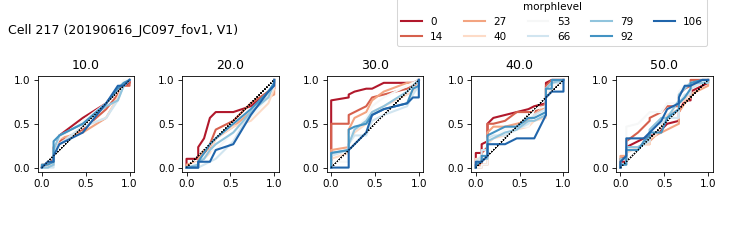

Text(0.01, 0.85, 'Cell 217 (20190616_JC097_fov1, V1)')

In [78]:
cmap='plasma' if param=='morphstep' else 'RdBu'
lw=2
# Plot----
mdiffs = sorted(aucs[param].unique())
mdiff_colors = sns.color_palette(cmap, n_colors=len(mdiffs))
colors = dict((k, v) for k, v in zip(mdiffs, mdiff_colors))

fig, axn = pl.subplots(1, len(sizes), figsize=(10,3))    
for mi, (sz, mp) in enumerate(resp_cfgs1):
    si = sizes.index(sz)
    ax=axn[si]
    if param=='morphstep':
        ax.plot(p_fas[mi, :], p_hits[mi, :], color=colors[mp], label=mp, lw=lw)
    else:
        ax.plot(p_fas[si, :], p_hits[mi, :], color=colors[mp], label=mp, lw=lw)
    ax.set_title(sz)
    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle=':', color='k', lw=1)
ax.legend(bbox_to_anchor=(1, 1.25), loc='lower right', title=param, ncol=5)
pl.subplots_adjust(left=0.05, right=0.95, bottom=0.2, hspace=0.5, wspace=0.5, top=0.7)
fig.text(0.01, 0.85, 'Cell %i (%s, %s)' % (rid, dk, va), fontsize=12)


In [29]:
importlib.reload(ps.psigniplot)

<module 'psignifit.psigniplot' from '/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py'>

In [79]:
# aucs, p_hits, p_fas, resp_cfgs1 = get_auc_AB(rdf, param=param, n_crit=50, reverse_eff=False,
#                   class_a=0, class_b=106, return_probs=True)

curr_sz=30
auc_ = aucs[aucs['size']==curr_sz].copy()
auc_['n_chooseB'] = auc_['AUC']*auc_['n_trials']
data_ = data_matrix_from_auc(auc_, param=param,normalize=True)
data_

array([[ 0.        , 28.        , 30.        ],
       [ 0.13207547, 24.        , 30.        ],
       [ 0.25471698, 23.        , 30.        ],
       [ 0.37735849, 20.        , 30.        ],
       [ 0.5       , 22.        , 30.        ],
       [ 0.62264151, 19.        , 30.        ],
       [ 0.74528302, 21.        , 30.        ],
       [ 0.86792453, 20.        , 30.        ],
       [ 1.        , 21.        , 30.        ]])

<IPython.core.display.Javascript object>


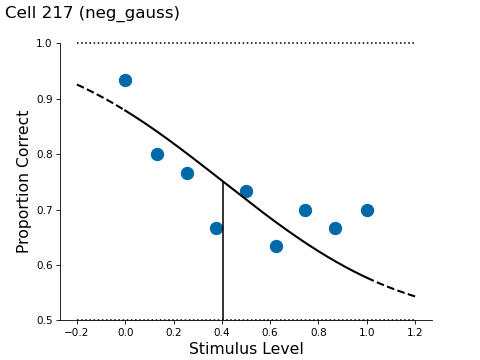

(array([], dtype=int64),)
[0.41 1.92 0.   0.5  0.  ]


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


Text(0.01, 0.95, 'Cell 217 (neg_gauss)')

In [82]:
fig, ax = pl.subplots()
ni = 0
opts = dict()
opts['sigmoidName'] = sigmoid_

opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
at_pc = 0.75 if opts['expType']=='2AFC' else 0.5
res_ = ps.psignifit(data_, opts)
print(res_['Fit'].round(2))
# norm: [0.74 1.27 0.   0.5  0.  ]
# gumbel: [0.76 1.18 0.   0.5  0.  ]
# neg_gumbel: [0.16 0.69 0.   0.5  0.  ]

# Weibull: [0.88 0.5  0.   0.5  0.  ]
# [0.78 0.91 0.   0.5  0.  ]
thr = ps.getThreshold(res_, at_pc)[0] # Value at which function reaches at_pc correct
slp = ps.getSlope(res_, ps.getThreshold(res_, at_pc)[0]) # Slope at given stimulus level

info_str = '(%i) %i (thr=%.2f,slope=%.2f)' % (ni, curr_sz, thr, slp)
ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=True, 
                             lineColor='k', label=info_str)
fig.text(0.01, 0.95, 'Cell %i (%s)' % (rid, sigmoid_), fontsize=16)

In [20]:
va, dk

('V1', '20190616_JC097_fov1')

In [83]:
# fig, ax = pl.subplots()

# for ni in range(10):
#     aucs, p_hits, p_fas, resp_cfgs1 = get_auc_AB(rdf, param=param, n_crit=50, reverse_eff=True,
#                       class_a=0, class_b=106, return_probs=True)

#     curr_sz=30
#     auc_ = aucs[aucs['size']==curr_sz].copy()
#     auc_['n_chooseB'] = auc_['AUC']*auc_['n_trials']
#     data_ = data_matrix_from_auc(auc_, param=param,normalize=True)


#     opts = dict()
#     opts['sigmoidname'] = 'gumbel'
#     opts['expType'] = '2AFC' #'2AFC'
#     opts['threshPC'] = 0.5
#     at_pc = 0.75 if opts['expType']=='2AFC' else 0.5
#     res_ = ps.psignifit(data_, opts)
#     print(res_['Fit'].round(2))
#     # norm: [0.59 1.54 0.   0.5  0.  ]
#     # gumbel: [0.59 1.54 0.   0.5  0.  ]
#     # Weibull: [0.88 0.5  0.   0.5  0.  ]

#     info_str = '(%i) %i (thr=%.2f,slope=%.2f)' % (ni, curr_sz, thr, slp)
#     ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=True, 
#                                  lineColor=size_colors[curr_sz], label=info_str)


## Fit by size - test 1 cell

In [32]:
cols = sns.color_palette('plasma', n_colors=5)
size_colors = dict((k, v) for k, v in zip(sizes, cols))

In [94]:
va = 'V1'
dk = '20190616_JC097_fov1'
rid = 217

aucs = AUC[(AUC.visual_area==va) & (AUC.datakey==dk) & (AUC['cell']==rid)].copy()
aucs.head()

cell  level_1  index       AUC  morphlevel  size  n_trials  Eff  \
99765   217        0      0  0.511111           0  10.0        30    0   
99766   217        1      1  0.452222          14  10.0        30    0   
99767   217        2      2  0.414444          27  10.0        30    0   
99768   217        3      3  0.416667          40  10.0        30    0   
99769   217        4      4  0.500000          53  10.0        30    0   

      visual_area              datakey  
99765          V1  20190616_JC097_fov1  
99766          V1  20190616_JC097_fov1  
99767          V1  20190616_JC097_fov1  
99768          V1  20190616_JC097_fov1  
99769          V1  20190616_JC097_fov1

In [95]:
opts = dict()
# opts['sigmoidName'] = sigmoid_
sig='norm'
opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
at_pc = 0.75 if opts['expType']=='2AFC' else 0.5
#res_ = ps.psignifit(data_, opts)

<IPython.core.display.Javascript object>


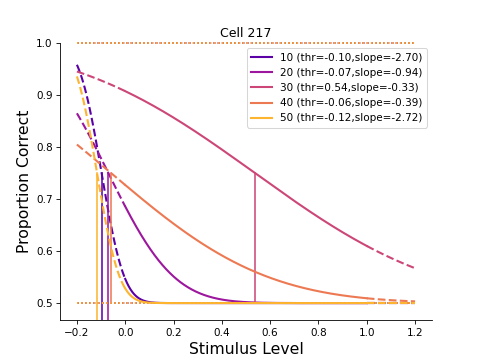

(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


In [96]:
cols = sns.color_palette('plasma', n_colors=5)
size_colors = dict((k, v) for k, v in zip(sizes, cols))


size_res={}
fig, ax = pl.subplots()
for curr_sz in sizes:
    auc_ = aucs[aucs['size']==curr_sz].copy()
    auc_['n_chooseB'] = auc_['AUC']*auc_['n_trials']
    Eff = int(auc_['Eff'].unique())
    sigmoid_ = 'neg_%s' % sig if Eff==0 else sig
    opts['sigmoidName'] = sigmoid_
    
    data_ = data_matrix_from_auc(auc_, param=param, normalize=True)
    res_ = ps.psignifit(data_, opts)
    try:
        thr = ps.getThreshold(res_, at_pc)[0] # Value at which function reaches at_pc correct
        slp = ps.getSlope(res_, ps.getThreshold(res_, at_pc)[0]) # Slope at given stimulus level
    except Exception as e:
        continue
#     print(curr_sz, thr, slp)
    info_str = '%i (thr=%.2f,slope=%.2f)' % (curr_sz, thr, slp)
    ax = ps.psigniplot.plotPsych(res_, axisHandle=ax, plotData=False, 
                                 lineColor=size_colors[curr_sz], label=info_str)
    size_res[curr_sz] = res_
    
ax.set_title('Cell %i' % (rid))
ax.legend()

In [70]:
mAUC.groupby(['visual_area', 'datakey', 'cell']).max()

level_1       AUC  morphlevel  size  \
visual_area datakey             cell                                        
Li          20190422_JC076_fov1 76         44  0.785556         106  50.0   
                                80         44  0.671111         106  50.0   
                                81         44  0.811111         106  50.0   
                                119        44  0.660000         106  50.0   
                                135        44  0.683333         106  50.0   
...                                       ...       ...         ...   ...   
V1          20191006_JC110_fov1 364        44  0.714533         106  50.0   
                                375        44  0.653298         106  50.0   
                                380        44  0.797683         106  50.0   
                                383        44  0.641003         106  50.0   
                                390        44  0.729779         106  50.0   

                                      n_trials  Eff  
visual_area datakey             cell                 
Li          20190422_JC076_fov1 76          30  106  
                                80          30    0  
                                81          30    0  
                                119         30    0  
                                135         30    0  
...                                        ...  ...  
V1          20191006_JC110_fov1 364         34  106  
                                375         34  106  
                                380         34  106  
                                383         34  106  
                                390         34  106  

[2763 rows x 6 columns]

##### baseline is baseline

In [497]:
# # ---------------

# def get_auc(rdf, n_crit=50):
#     #cfgs = sorted(rdf['config'].unique())
#     #rid = float(rdf['cell'].unique())
#     resp_stim = [g['response'].values for c, g in  rdf.groupby(['config'])]
#     resp_bas = [g['baseline'].values for c, g in  rdf.groupby(['config'])]
#     cfgs = [c for c, g in  rdf.groupby(['config'])]
#     n_conditions = len(resp_stim)
#     p_hits, p_fas, crit_vals = get_hits_and_fas(resp_stim, resp_bas, n_crit=n_crit)

#     true_auc = [-np.trapz(p_hits[ci, :], x=p_fas[ci, :]) for ci in np.arange(0, n_conditions)]
#     aucs = pd.DataFrame({'AUC': true_auc, 'config': cfgs})
    
#     return aucs, p_hits, p_fas

# Test fit -- all cells in 1 fov

In [142]:
import psignifit as ps

In [91]:
va='V1'
dk = '20190616_JC097_fov1'

aucs = mAUC[(mAUC.visual_area==va) & (mAUC.datakey==dk)].copy()
# aucs = mAUC[(mAUC.visual_area==va)].copy()

aucs.head()
print(aucs.shape)

(8280, 9)


In [92]:
max_auc=0.7
pass_cells = aucs[aucs['AUC']>=max_auc]['cell'].unique()
print("%i of %i cells pass crit (%.2f)" % (len(pass_cells), len(aucs['cell'].unique()), max_auc))
pass_auc = aucs[aucs['cell'].isin(pass_cells)].copy()

101 of 184 cells pass crit (0.70)


In [113]:
best_config_only=False

if best_config_only:
    # Best config (size) for each cell
    max_auc_ixs = pass_auc.groupby(['cell'])['AUC'].transform(max) == pass_auc['AUC']
    best_sz_per_cell = [(r, c) for (r, c), g in pass_auc[max_auc_ixs].groupby(['cell', 'size'])]
    assert len(pass_cells)==len(best_sz_per_cell)
    best_auc = pd.concat([g for (r,c), g in pass_auc.groupby(['cell', 'size']) if (r, c) in best_sz_per_cell])
else:
    best_auc = pass_auc.copy()
    
best_auc.head()


cell  level_1       AUC  morphlevel  size  n_trials  Eff visual_area  \
95535     9        0  0.555556           0  10.0        30    0          V1   
95536     9        1  0.481111          14  10.0        30    0          V1   
95537     9        2  0.508889          27  10.0        30    0          V1   
95538     9        3  0.555556          40  10.0        30    0          V1   
95539     9        4  0.494444          53  10.0        30    0          V1   

                   datakey  
95535  20190616_JC097_fov1  
95536  20190616_JC097_fov1  
95537  20190616_JC097_fov1  
95538  20190616_JC097_fov1  
95539  20190616_JC097_fov1

In [94]:
importlib.reload(ps)

<module 'psignifit' from '/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/__init__.py'>

In [115]:
opts = dict()
sig = 'norm'

opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
at_pc = 0.75 if opts['expType']=='2AFC' else 0.5

In [ ]:
results=dict((k, {s: None}) for (k, s), g in best_auc.groupby(['cell', 'size']))

d_=[]

conds = [(r, s) for (r, s), g in best_auc.groupby(['cell', 'size'])]

for ri, ((rid, sz), auc_r) in enumerate(best_auc.groupby(['cell', 'size'])):
    if ri%10==0:
        print("...%i of %i " % (int(ri+1), len(conds)))
        
    Eff = int(auc_r['Eff'].unique())
    sigmoid_ = 'neg_%s' % sig if Eff==0 else sig
    opts['sigmoidName'] = sigmoid_
    
    data = data_matrix_from_auc(auc_r, param=param)
    res = ps.psignifit(data, opts)
    results[rid][sz] = res
    df_ = pd.DataFrame(res['Fit'], index=param_names, columns=[rid]).T
    try:
        thr = ps.getThreshold(res, 0.75)[0] # Value at which function reaches at_pc correct
        slp = ps.getSlope(res, ps.getThreshold(res, 0.75)[0]) # Slope at given stimulus level
    except Exception as e:
        thr=None
        slp=None
    df_['slope'] = slp
    df_['thr'] = thr
    df_['cell'] = rid
    df_['size'] = sz
    df_['sigmoid'] = sigmoid_
    
    d_.append(df_)


...1 of 505 
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e9b7320>


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  CI = np.zeros([len(result['options']['confP']),2])


HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e9b78c0>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e9b7e60>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e1b0440>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e1b09e0>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e1b0f80>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e13a560>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e13ab00>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e1380e0>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e138680>
...11 of 505 
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e138b90>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e13c200>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e13c7a0>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e13cd40>
HANDLE: <function getSigmoidHandle.<locals>.<lambd

HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e680320>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e6808c0>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e680e60>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e68e440>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e68e9e0>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e68ef80>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e698560>
...121 of 505 
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e698a70>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e6a90e0>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e6a9680>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e6a9c20>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e6b6200>
HANDLE: <function getSigmoidHandle.<locals>.<lambda> at 0x7f9a3e6b67a0>
HANDLE: <function getSigmoidHandle.<locals>.<lamb

In [134]:
estimates = pd.concat(d_, axis=0)
print(estimates.shape)
estimates.head()

(505, 10)


threshold       width        lambda  gamma           eta     slope  \
9  -8.134347   25.742626  1.770664e-06    0.5  3.626514e-05 -0.025491   
9 -13.307578  128.357960  2.676204e-13    0.5  6.116363e-06 -0.005112   
9 -14.975346  110.056106  1.325393e-12    0.5  1.794314e-13 -0.005962   
9 -10.370745   25.732207  7.373378e-12    0.5  2.267188e-05 -0.025501   
9 -13.914133  187.301629  5.924162e-13    0.5  1.256341e-07 -0.003503   

         thr  cell  size   sigmoid  
9  -8.134382     9  10.0  neg_norm  
9 -13.307578     9  20.0  neg_norm  
9 -14.975346     9  30.0  neg_norm  
9 -10.370745     9  40.0  neg_norm  
9 -13.914133     9  50.0  neg_norm

In [135]:
max_x

106.0

In [136]:
max_x = float(aucs[param].max())

pass_estimates = estimates[(estimates['threshold']>=0) & (estimates['threshold']<=max_x)].dropna()

fit_cells = pass_estimates.index.tolist()
print('%i cells with valid fits' % len(fit_cells))

72 cells with valid fits


<IPython.core.display.Javascript object>


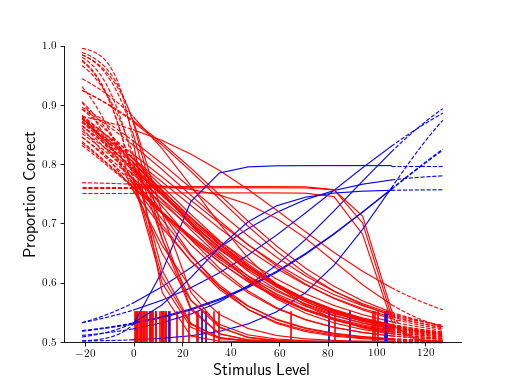

In [103]:

fig, ax = pl.subplots()
for ri, est in pass_estimates.groupby(['size']):
    ai = ax
    res = results[ri]
    lcolor = [1, 0, 0] if 'neg_' in res['options']['sigmoidName'] else [0, 0, 1]
    ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False,
                               thresh_height=0.55, npoints=10, lineColor=lcolor)

<IPython.core.display.Javascript object>


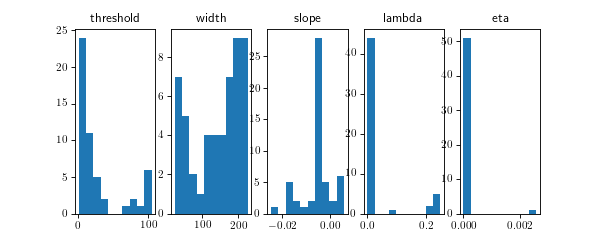

In [109]:
plot_params = ['threshold', 'width', 'slope', 'lambda', 'eta']
fig, axn = pl.subplots(1, len(plot_params), figsize=(len(plot_params)*1.5, 3))
for ax, p in zip(axn.flat, plot_params):
    sns.histplot(pass_estimates[p], hue='')

In [111]:
pass_estimates.head()

threshold       width        lambda  gamma           eta     slope  \
11   29.723928  145.238698  2.140558e-01    0.5  3.959836e-13  0.001274   
12   17.767120  217.660086  3.096635e-07    0.5  1.389371e-12 -0.003382   
15    7.449973  148.529284  1.099547e-07    0.5  2.704609e-12 -0.004956   
16  100.466721   24.670966  2.396872e-01    0.5  1.953780e-11 -0.002364   
24    0.904706  136.592730  5.038400e-12    0.5  2.964760e-13 -0.005389   

          thr  cell  
11  77.558080    11  
12  17.767074    12  
15   7.449962    15  
16  87.110532    16  
24   0.904706    24

In [115]:
max_auc=0.7
opts = dict()
sig = 'gauss'

opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
at_pc = 0.75 if opts['expType']=='2AFC' else 0.5

dk = '20190616_JC097_fov1'
va = 'V1'

currAUC = AUC[(AUC.visual_area==va) & (AUC.datakey==dk)].copy()

for (va, dk), currAUC in AUC.groupby(['datakey']):
    traceid_dir = get_tracedir_from_datakey(dk)
    curr_dst_dir = os.path.join(traceid_dir, 'neurometric', 'fits')
    if not os.path.exists(curr_dst_dir):
        os.makedirs(curr_dst_dir)
    print("Saving ROI results to:\n   %s" % curr_dst_dir)

    # Cells that pass performance criterion
    pass_cells = currAUC[currAUC['AUC']>=max_auc]['cell'].unique()

    print("%i of %i cells pass crit (%.2f)" % (len(pass_cells), len(currAUC['cell'].unique()), max_auc))
    pass_auc = currAUC[currAUC['cell'].isin(pass_cells)].copy()
    if len(pass_cells)==0:
        print("****[%s, %s] no cells." % (va, dk))

    for rid, auc_r in pass_auc.groupby(['cell']):
        fn = '%s_rid%03d.pkl' % (sigmoid_, rid)
        outfile = os.path.join(curr_dst_dir, fn)
        if os.path.exists(outfile):
            continue

        results={}
        for sz, auc_sz in auc_r.groupby(['size']):
            # format data
            data = data_matrix_from_auc(auc_sz, param=param)

            # fit
            Eff = int(auc_r['Eff'].unique())
            sigmoid_ = 'neg_%s' % sig if Eff==0 else sig

            opts['sigmoidName'] = sigmoid_
            res = ps.psignifit(data, opts)
            results[sz] = res

        fn = '%s_rid%03d.pkl' % (sigmoid_, rid)
        outfile = os.path.join(curr_dst_dir, fn)

        with open(outfile, 'wb') as f:
            pkl.dump(results, f, protocol=2)
        print("... saved: %s" % fn)


Saving ROI results to: /n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_d1a2cd_traces001_a13a76_traces001_0a4432_traces001_6fc2ca_traces001_2449cf_traces001_70650b/neurometric/fits
104 of 184 cells pass crit (0.70)
(array([], dtype=int64),)


/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid000.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid009.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid015.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid016.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid017.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid037.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(a

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid219.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: gauss_rid221.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid223.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid224.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid232.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid233.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array

(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid424.pkl
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
... saved: neg_gauss_rid425.pkl


In [130]:
os.listdir(curr_dst_dir)

['neg_gauss_rid217.pkl',
 'neg_gauss_rid000.pkl',
 'neg_gauss_rid009.pkl',
 'neg_gauss_rid015.pkl',
 'neg_gauss_rid016.pkl',
 'neg_gauss_rid017.pkl',
 'neg_gauss_rid037.pkl',
 'neg_gauss_rid045.pkl',
 'neg_gauss_rid050.pkl',
 'neg_gauss_rid054.pkl',
 'neg_gauss_rid062.pkl',
 'neg_gauss_rid063.pkl',
 'neg_gauss_rid064.pkl',
 'gauss_rid065.pkl',
 'neg_gauss_rid068.pkl',
 'neg_gauss_rid069.pkl',
 'neg_gauss_rid081.pkl',
 'neg_gauss_rid087.pkl',
 'gauss_rid090.pkl',
 'neg_gauss_rid106.pkl',
 'neg_gauss_rid108.pkl',
 'neg_gauss_rid109.pkl',
 'gauss_rid117.pkl',
 'gauss_rid132.pkl',
 'neg_gauss_rid141.pkl',
 'neg_gauss_rid142.pkl',
 'neg_gauss_rid143.pkl',
 'neg_gauss_rid144.pkl',
 'neg_gauss_rid145.pkl',
 'gauss_rid147.pkl',
 'neg_gauss_rid150.pkl',
 'neg_gauss_rid153.pkl',
 'neg_gauss_rid156.pkl',
 'neg_gauss_rid157.pkl',
 'neg_gauss_rid165.pkl',
 'neg_gauss_rid168.pkl',
 'neg_gauss_rid170.pkl',
 'neg_gauss_rid171.pkl',
 'neg_gauss_rid173.pkl',
 'neg_gauss_rid185.pkl',
 'neg_gauss_rid187.p

## Test loading

In [116]:
dk
traceid_dir = get_tracedir_from_datakey(dk)
print(traceid_dir)

/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_d1a2cd_traces001_a13a76_traces001_0a4432_traces001_6fc2ca_traces001_2449cf_traces001_70650b


In [127]:
# Cells that pass performance criterion
pass_cells = currAUC[currAUC['AUC']>=max_auc]['cell'].unique()
print("%i of %i cells pass crit (%.2f)" % (len(pass_cells), len(currAUC['cell'].unique()), max_auc))
pass_auc = currAUC[currAUC['cell'].isin(pass_cells)].copy()
if len(pass_cells)==0:
    print("****[%s, %s] no cells." % (va, dk))


# Best config (size) for each cell
max_auc_ixs = pass_auc.groupby(['cell'])['AUC'].transform(max) == pass_auc['AUC']
ix = pass_auc[max_auc_ixs]['cell'].drop_duplicates().index.tolist()
best_sz_per_cell = [(r, c) for (r, c), g in pass_auc.loc[ix].groupby(['cell', 'size'])]
assert len(pass_cells)==len(best_sz_per_cell)
if len(best_sz_per_cell)==0:
    print("****[%s, %s] no cells." % (va, dk))

best_auc = pd.concat([g for (r,c), g in pass_auc.groupby(['cell', 'size']) if (r, c) in best_sz_per_cell])


104 of 184 cells pass crit (0.70)


<IPython.core.display.Javascript object>


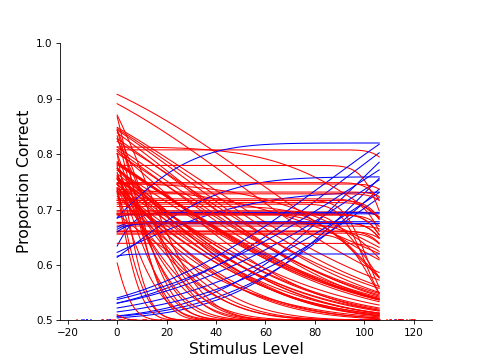

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bo

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bo

/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')
/n/coxfs01/2p-pipeline/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bo

In [139]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']

fig, ax = pl.subplots()

d_ = []

for r, g in best_auc.groupby(['cell']):

    fn = glob.glob(os.path.join(traceid_dir, 'neurometric', 'fits', '*_rid%03d.pkl' % r))[0]
    with open(fn, 'rb') as f:
        curr_res = pkl.load(f)
    curr_sz = int(g['size'].unique())
    res = curr_res[curr_sz]
    color= [1, 0, 0] if 'neg' in res['options']['sigmoidName'] else [0, 0, 1]
    ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False,
                               thresh_height=0.1, npoints=500, extrapolLength=0, lineColor=color)
    
        
    df_ = pd.DataFrame(res['Fit'], index=param_names, columns=[r]).T
    try:
        thr = ps.getThreshold(res, 0.75)[0] # Value at which function reaches at_pc correct
        slp = ps.getSlope(res, ps.getThreshold(res, 0.75)[0]) # Slope at given stimulus level
    except Exception as e:
        thr=None
        slp=None
    df_['slope'] = slp
    df_['thr'] = thr
    df_['cell'] = r
    df_['size'] = curr_sz
    d_.append(df_)
    
est = pd.concat(d_, axis=0)

In [134]:
res.keys()

dict_keys(['X1D', 'marginals', 'marginalsX', 'marginalsW', 'Posterior', 'logPmax', 'weight', 'integral', 'Fit', 'options', 'data', 'conf_Intervals', 'timestamp'])

In [691]:
max_auc=0.7
opts = dict()
sig = 'logistic'

opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
at_pc = 0.75 if opts['expType']=='2AFC' else 0.5

e_=[]
R = dict((k, {v: None}) for (k, v), g in mAUC.groupby(['visual_area', 'datakey']))

for (va, dk), aucs in AUC.groupby(['visual_area', 'datakey']):

    #aucs = mAUC[(mAUC.visual_area==va)].copy()
    if dk in R[va].keys() and isinstance(R[va][dk], dict): #@ is not None:
        continue
        
    traceid_dir = get_tracedir_from_datakey(dk)
    curr_dst_dir = os.path.join(traceid_dir, 'neurometric', 'fits')
    if not os.path.exists(curr_dst_dir):
        os.makedirs(cur_dst_dir)
        
    # Cells that pass performance criterion
    pass_cells = aucs[aucs['AUC']>=max_auc]['cell'].unique()
    print("%i of %i cells pass crit (%.2f)" % (len(pass_cells), len(aucs['cell'].unique()), max_auc))
    pass_auc = aucs[aucs['cell'].isin(pass_cells)].copy()
    if len(pass_cells)==0:
        print("****[%s, %s] no cells." % (va, dk))
        continue

    # Best config (size) for each cell
#     max_auc_ixs = pass_auc.groupby(['cell'])['AUC'].transform(max) == pass_auc['AUC']
#     ix = pass_auc[max_auc_ixs]['cell'].drop_duplicates().index.tolist()
#     best_sz_per_cell = [(r, c) for (r, c), g in pass_auc.loc[ix].groupby(['cell', 'size'])]
#     assert len(pass_cells)==len(best_sz_per_cell)
#     if len(best_sz_per_cell)==0:
#         print("****[%s, %s] no cells." % (va, dk))
#         continue
#     best_auc = pd.concat([g for (r,c), g in pass_auc.groupby(['cell', 'size']) if (r, c) in best_sz_per_cell])

    
    d_=[]
    for rid, auc_r in pass_auc.groupby(['cell']):
        results={}
        for sz, auc_sz in auc_r.groupby(['size']):
            # format data
            data = data_matrix_from_auc(auc_sz, param=param)

            # fit
            Eff = int(auc_r['Eff'].unique())
            sigmoid_ = 'neg_%s' % sig if Eff==0 else sig

            opts['sigmoidName'] = sigmoid_
            res = ps.psignifit(data, opts)
            results[sz] = res
        
        outfile = os.path.join(curr_dst_dir, '%s_rid%03d.pkl' % (sigmoid_, rid))

        with open(outfile, 'wb') as f:
            pkl.dump(results, f, protocol=2)

        
        df_ = pd.DataFrame(res['Fit'], index=param_names, columns=[rid]).T
        try:
            thr = ps.getThreshold(res, 0.75)[0] # Value at which function reaches at_pc correct
            slp = ps.getSlope(res, ps.getThreshold(res, 0.75)[0]) # Slope at given stimulus level
        except Exception as e:
            thr=None
            slp=None
        df_['slope'] = slp
        df_['thr'] = thr
        d_.append(df_)
    est = pd.concat(d_, axis=0)
    est['cell'] = est.index.tolist()
    est['visual_area'] = va
    est['datakey'] = dk
    e_.append(est)
    
    R[va][dk] = results
    

0 of 6 cells pass crit (0.70)
****[V1, 20190517_JC083_fov1] no cells.
48 of 92 cells pass crit (0.70)
(array([], dtype=int64),)


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], d

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


In [692]:
for k, v in R.items():
    for kk, vv in v.items():
        if vv is None:
            print(k, kk, vv)

In [693]:
estimates = pd.concat(e_).reset_index(drop=True)
estimates.head()

threshold     width        lambda  gamma           eta     slope       thr  \
0   4.532189  1.966370  1.557351e-10    0.5  2.685067e-09  0.333712  4.532189   
1   3.892998  1.914792  1.401999e-08    0.5  1.602869e-07  0.342701  3.892998   
2   4.509790  5.885670  5.069362e-05    0.5  9.112391e-11  0.111480  4.510017   
3   4.728790  1.927109  4.139367e-07    0.5  4.126728e-05  0.340511  4.728791   
4   4.054206  2.864205  3.899546e-05    0.5  6.835823e-11  0.229086  4.054291   

   cell visual_area              datakey  
0   186          Li  20190422_JC076_fov1  
1   261          Li  20190422_JC076_fov1  
2   269          Li  20190422_JC076_fov1  
3   277          Li  20190422_JC076_fov1  
4   292          Li  20190422_JC076_fov1

In [727]:
# res_outfile = os.path.join(src_data_dir, 'results.pkl')
# with open(res_outfile, 'wb') as f:
#     pkl.dump({'R': R, 'estimates': estimates}, f, protocol=2)

res_outfile = os.path.join(src_data_dir, 'results.pkl')
with open(res_outfile, 'wb') as f:
    pkl.dump({'estimates': estimates, 'AUC': mAUC}, f, protocol=2)

In [726]:
# jupyter notebook --NotebookApp.iopub_msg_rate_limit=10000

res_outfile = os.path.join(src_data_dir, 'R.pkl')
with open(res_outfile, 'wb') as f:
    pkl.dump({'R': R}, f, protocol=2)

AttributeError: Can't pickle local object 'normalizeFunction.<locals>.<lambda>'

In [704]:
importlib.reload(ps.psigniplot)


<module 'psignifit.psigniplot' from '/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py'>

In [ ]:
ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False

In [9]:
param='morphstep'
max_x = float(mAUC[param].max())
visual_areas = ['V1', 'Lm', 'Li']
print(max_x)
pass_estimates = estimates[(estimates['threshold']>=0) & (estimates['threshold']<=max_x)].dropna()

4.0


In [18]:
pass_estimates.dtypes

threshold      float64
width          float64
lambda         float64
gamma          float64
eta            float64
slope          float64
thr            float64
cell             int64
visual_area     object
datakey         object
dtype: object

106.0


<IPython.core.display.Javascript object>


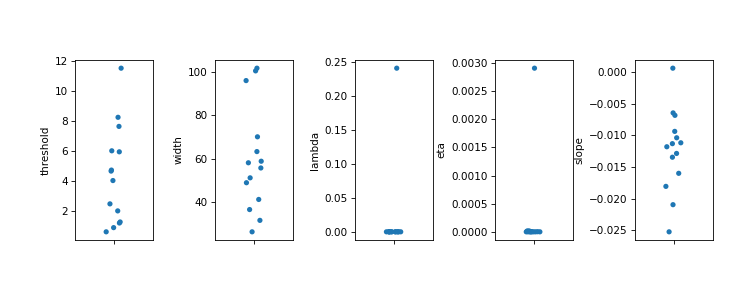

In [146]:
max_x = float(mAUC[param].max())
pass_estimates = est[(est['threshold']>=0) & (est['threshold']<=max_x)
                    & (est['width']<=max_x)].dropna()

visual_areas = ['V1', 'Lm', 'Li']
print(max_x)

param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
plot_params = ['threshold', 'width', 'lambda', 'eta','slope']

n_params = len(param_names)

fig, axn = pl.subplots(1, len(plot_params), figsize=(len(plot_params)*2, 4))
for ax, p in zip(axn.flat, plot_params):
    sns.stripplot(y=p, data=pass_estimates, ax=ax)
    
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.8)

<IPython.core.display.Javascript object>


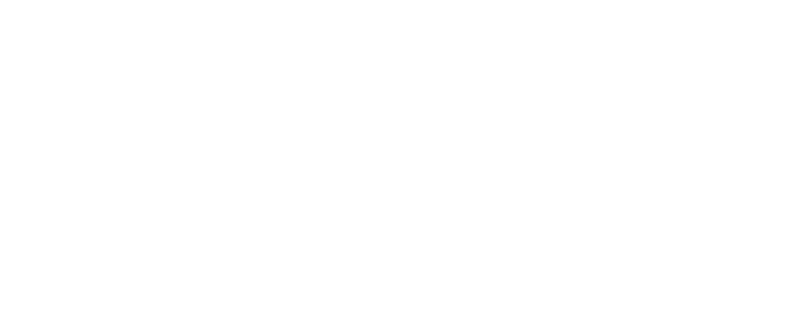

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [716]:
fig, axn = pl.subplots(1,3, figsize=(10,4))
for (va, dk), est in pass_estimates.groupby(['visual_area','datakey']):
    results = R[va][dk]
    curr_fit_cells = est['cell'].unique()
    
    ai = visual_areas.index(va)
    ax=axn[ai]
    for rid, res in results.items():
        if rid not in curr_fit_cells:
            continue
        ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False,
                               thresh_height=0.1, npoints=10)
    ax.set_title(va, fontsize=24)
pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, top=0.8, wspace=0.5)


<IPython.core.display.Javascript object>


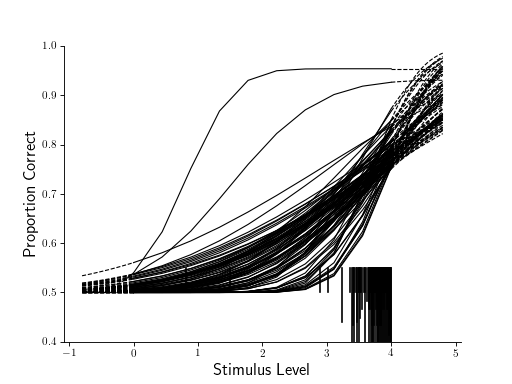

In [717]:
va='Lm'

fig, ax = pl.subplots()
for dk, est in pass_estimates[pass_estimates.visual_area==va].groupby(['datakey']):
    results = R[va][dk]
    curr_fit_cells = est['cell'].unique()
    for rid, res in results.items():
        if rid not in curr_fit_cells:
            continue
        ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False,
                               thresh_height=0.55, npoints=10)

<IPython.core.display.Javascript object>


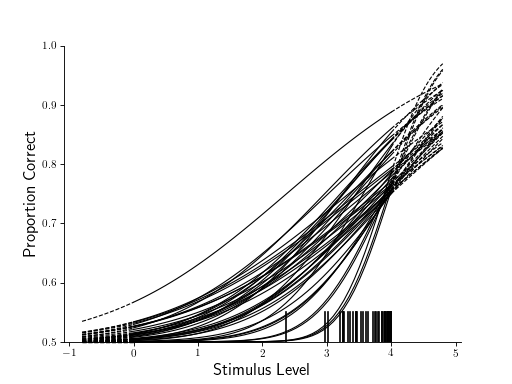

In [712]:
va='Li'

fig, ax = pl.subplots()
for dk, est in pass_estimates[pass_estimates.visual_area==va].groupby(['datakey']):
    results = R[va][dk]
    curr_fit_cells = est['cell'].unique()
    for rid, res in results.items():
        if rid not in curr_fit_cells:
            continue
        ps.psigniplot.plotPsych(res, axisHandle=ax, plotData=False, lineWidth=1, plotAsymptote=False,
                               thresh_height=0.55, npoints=50)

In [718]:
pass_estimates.head()

threshold     width        lambda  gamma           eta     slope  \
1    3.892998  1.914792  1.401999e-08    0.5  1.602869e-07  0.342701   
10   3.908429  3.619414  5.050646e-11    0.5  9.843335e-10  0.181301   
11   3.473057  7.589552  4.058454e-09    0.5  6.106602e-09  0.086461   
12   3.524935  7.561378  1.453119e-08    0.5  3.145398e-10  0.086783   
13   3.904229  5.447926  6.400028e-08    0.5  2.762301e-11  0.120450   

         thr  cell visual_area              datakey  
1   3.892998   261          Li  20190422_JC076_fov1  
10  3.908429    37          Li  20190602_JC091_fov1  
11  3.473057    38          Li  20190602_JC091_fov1  
12  3.524935    39          Li  20190602_JC091_fov1  
13  3.904230    40          Li  20190602_JC091_fov1

In [10]:
mean_est = pass_estimates.groupby(['visual_area', 'datakey']).mean().reset_index()

<IPython.core.display.Javascript object>


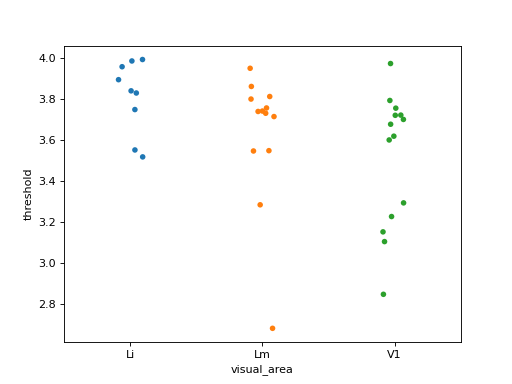

<AxesSubplot:xlabel='visual_area', ylabel='threshold'>

In [11]:
fig, ax = pl.subplots()
sns.stripplot(x='visual_area', y='threshold', data=mean_est, ax=ax)

<IPython.core.display.Javascript object>


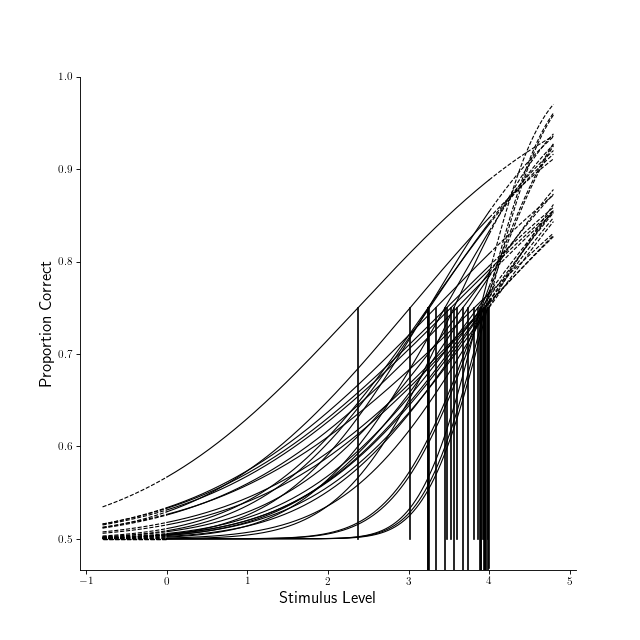

<IPython.core.display.Javascript object>


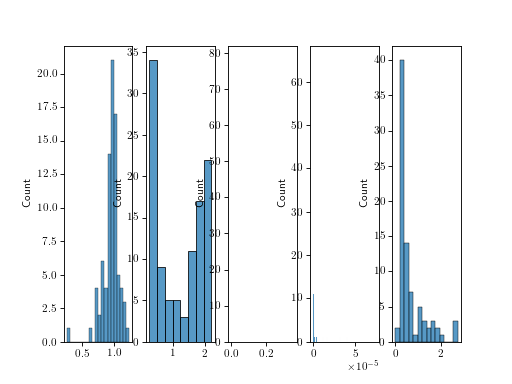

In [371]:
fig, axn = pl.subplots(1, n_params)
for ax, p in zip(axn.flat, ['threshold', 'width', 'lambda', 'eta', 'slope']):
    sns.histplot(data=estimates[p].values, ax=ax)



# Stimuli

In [40]:
morphlevels = SDF['20190616_JC097_fov1']['morphlevel'].unique()
stimdir = '/n/coxfs01/behavior-data/stimuli/D1D2M105_yrot_fine_steps/final'
curr_morphs = [m for m in sorted(morphlevels) if m!=-1]

image_fns = [os.path.join(stimdir, 'morph%i_y0.png' % m) for m in curr_morphs]
images={}
for m, fn in zip(curr_morphs, image_fns):
    images[m] = pl.imread(fn)

In [45]:
morph_lut, a_morphs, b_morphs = get_morph_levels()


In [46]:
morph_steps={}
for k, v in morph_lut.items():
    if v not in morph_steps.keys():
        morph_steps[v] =[]
    morph_steps[v].append(k)
morph_steps

{1: [40, 66], 2: [27, 79], 3: [14, 92], 4: [0, 106], 0: [53], -1: [-1]}

In [47]:
morphsteps = sorted([k for k, v in morph_steps.items() if k>=0])
morphsteps

[0, 1, 2, 3, 4]

<IPython.core.display.Javascript object>


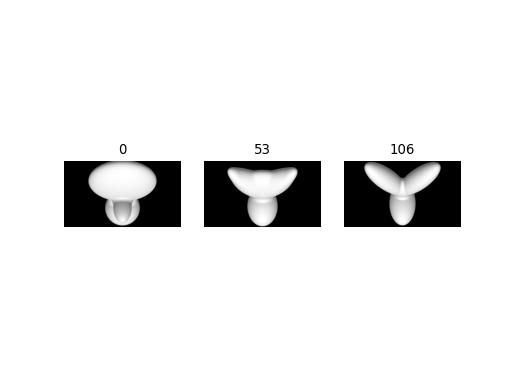

In [48]:
fig, axn = pl.subplots(1,3)
for ax, m in zip(axn.flat, [0, 53, 106]):
    ax.imshow(images[m], cmap='gray')
    ax.set_title(m)
    ax.axis('off')

<IPython.core.display.Javascript object>


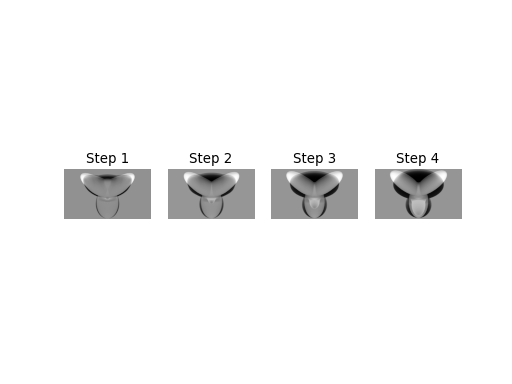

In [51]:
fig, axn = pl.subplots(1, len(morphsteps)-1)
diffs = {}
d=[]
for mstep, mims in morph_steps.items():
    if mstep <=0:
        continue
    ai = mstep-1
    ax = axn[ai]
    im1 = images[mims[0]]
    im2 = images[mims[1]] 
    diff_im = im1 - im2
    ax.imshow(diff_im, cmap='Greys')
    ax.axis('off')
    d.append(np.sum(diff_im))
    
    ediff = sp.spatial.distance.euclidean(im1.ravel(), im2.ravel())
    
    diffs[mstep] = ediff
    ax.set_title("Step %i" % mstep)
diffs.update({0: 0})


<IPython.core.display.Javascript object>


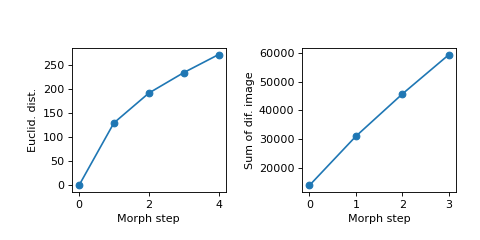

In [56]:
fig, axn = pl.subplots(1,2, figsize=(6,3))
ax=axn[0]
ax.plot(morphsteps, [diffs[v] for v in morphsteps], marker='o')
ax.set_xlabel('Morph step')
ax.set_ylabel('Euclid. dist.')

ax=axn[1]
ax.plot(d, marker='o')
ax.set_xlabel('Morph step')
ax.set_ylabel('Sum of dif. image')

pl.subplots_adjust(left=0.15, right=0.95, bottom=0.2, wspace=0.5, top=0.8)


In [620]:
diffs

{1: 129.56948852539062,
 2: 191.359619140625,
 3: 233.80543518066406,
 4: 271.2908630371094}

In [625]:
np.linalg.norm(im2-im1)

271.29086

<IPython.core.display.Javascript object>


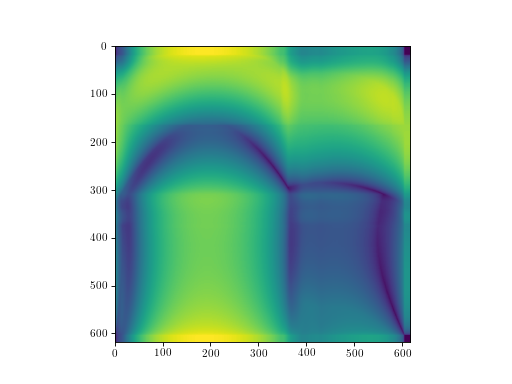

In [630]:
d1 = sp.spatial.distance.cdist(im2, im1, 'euclidean')
pl.figure()
pl.imshow(d1)

In [636]:
np.sum(diff_im)


-59371.383

In [343]:
pd.DataFrame(res['Fit'], index=param_names, columns=[rid]).T


threshold     width        lambda  gamma           eta
217   0.807907  0.688368  1.084300e-09    0.5  2.040462e-07

In [323]:
rid = 217

auc_r = best_auc[(best_auc['cell']==rid)].copy()
data = data_matrix_from_auc(auc_r)
data

array([[ 0.        , 14.        , 30.        ],
       [ 0.13207547, 17.        , 30.        ],
       [ 0.25471698, 18.        , 30.        ],
       [ 0.37735849, 15.        , 30.        ],
       [ 0.5       , 18.        , 30.        ],
       [ 0.62264151, 17.        , 30.        ],
       [ 0.74528302, 21.        , 30.        ],
       [ 0.86792453, 23.        , 30.        ],
       [ 1.        , 28.        , 30.        ]])

In [353]:
ps.getThreshold(res, 0.75)[0] # Value at which function reaches at_pc correct
ps.getSlope(res, ps.getThreshold(res, 0.75)[0]) # Slope at given stimulus level

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psignifit.py:717: UserWarning: The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.
  warnings.warn('The CIs computed by this method are only upper bounds. For more accurate inference change threshPC in the options.')


0.807906798155016

In [357]:
ps.getSlope(res, ps.getThreshold(res, 0.75)[0])

0.9532720278663362

In [324]:
opts = dict()
opts['sigmoidName'] = 'weibull'
opts['expType'] = '2AFC' #'2AFC'
opts['threshPC'] = 0.5
#opts['stepN']= [25,20,10,20]  #[40,40,50,20,20]
#  [threshold, width, upper asymptote, lower asymptote, variance scaling] 
# opts['borders'] = bounds
# opts['moveBorders'] = False
# opts['priors'] = priors
res = ps.psignifit(data, opts)


(array([], dtype=int64),)


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [21]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
n_params = len(param_names)
#first lets have a look at the results with the standard prior strength:
# print('Fit:', res['Fit'].round(2))


<IPython.core.display.Javascript object>


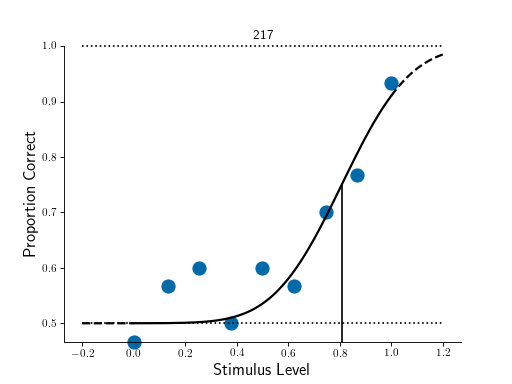

Text(0.5, 1.0, '217')

In [326]:
fig, ax = pl.subplots()
ax = ps.psigniplot.plotPsych(res, axisHandle=ax)
ax.set_title(rid)

# figname = 'psychometric_%s' % animalid
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

In [333]:
ps.getThreshold(res, 0.75)


(0.807906798155016,
 array([[0.57525885, 1.44231971],
        [0.6195629 , 1.24934457],
        [0.69767686, 1.00144201]]))

In [335]:
ps.getThreshold(res, 0.75, 1)

(0.9490430475764219,
 array([[0.63759465, 1.35223187],
        [0.69325121, 1.27614412],
        [0.80064194, 1.13613742]]))

In [334]:
ps.getSlope(res, 0.75)


0.9174598161274641

In [247]:
res['options']['sigmoidHandle']

<function psignifit.getSigmoidHandle.getSigmoidHandle.<locals>.<lambda>(X, m, width)>

<IPython.core.display.Javascript object>


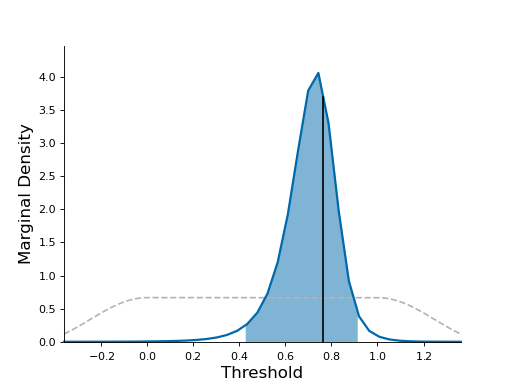

In [28]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
n_params = len(param_names)

pi = 0
par = param_names[pi]
fig, ax = pl.subplots()

ax=ps.psigniplot.plotMarginal(res_, dim=pi, axisHandle=ax)


<IPython.core.display.Javascript object>


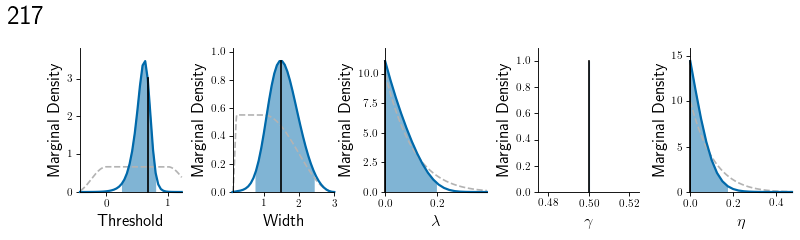

Error: The parameter you wanted to plot was fixed in the analysis!


/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:324: UserWarning: Attempting to set identical left == right == 0.5 results in singular transformations; automatically expanding.
  plt.xlim([min(x), max(x)])


Text(0.01, 0.9, '217')

In [34]:
param_names = ['threshold', 'width', 'lambda', 'gamma', 'eta']
n_params = len(param_names)
fig, axn = pl.subplots(1, n_params, figsize=(10,3))

for pi, par in enumerate(param_names):
    ax=axn[pi]
    ax=ps.psigniplot.plotMarginal(res_, dim=pi, axisHandle=ax)
pl.subplots_adjust(left=0.1, right=0.99, bottom=0.2, wspace=0.5, top=0.8)

fig.text(0.01, 0.9, rid, fontsize=24)

# figname = 'marginals_%s' % animalid
# pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
# print(curr_dst_dir, figname)

<IPython.core.display.Javascript object>


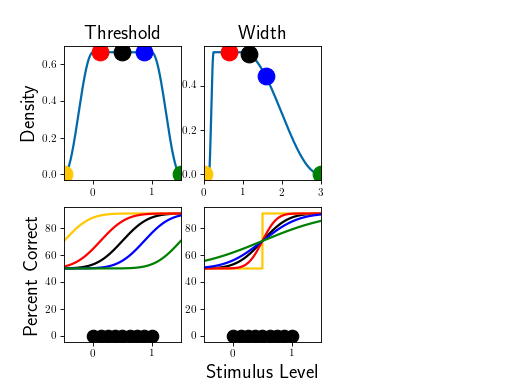

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:443: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,3,4)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:445: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(2,3,1)
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/psignifit/psigniplot.py:443: Ma

In [250]:
fig, ax = pl.subplots()
ps.psigniplot.plotPrior(res) #,axisHandle=ax)

# Goodness of fit

In [35]:
def getDeviance(result,Nsamples=None):
    fit = result['Fit']
    data = result['data']
    pPred = fit[3] + (1-fit[2]-fit[3]) * result['options']['sigmoidHandle'](data[:,0], fit[0], fit[1])
    
    pMeasured = data[:,1]/data[:,2]
    loglikelihoodPred = data[:,1]*np.log(pPred)+(data[:,2]-data[:,1])*np.log((1-pPred))
    loglikelihoodMeasured = data[:,1]*np.log(pMeasured)+(data[:,2]-data[:,1])*np.log((1-pMeasured))
    loglikelihoodMeasured[pMeasured==1] = 0;
    loglikelihoodMeasured[pMeasured==0] = 0;

    #devianceResiduals = -2*np.sign(pMeasured-pPred)*(loglikelihoodMeasured - loglikelihoodPred)
    #deviance = np.sum(np.abs(devianceResiduals))
    devianceResiduals = np.sign(pMeasured-pPred)*np.sqrt(2*(loglikelihoodMeasured - loglikelihoodPred))
    deviance = np.sum(devianceResiduals**2)
    
    if Nsamples is None:
        return devianceResiduals,deviance
    else: 
        r_vals=[]
        samples_devianceResiduals = np.zeros((Nsamples,data.shape[0]))
        for iData in range(data.shape[0]):
            samp_dat = np.random.binomial(data[iData,2],pPred[iData],Nsamples)
            #print(samp_dat)
            pMeasured = samp_dat/data[iData,2]
            #print(pMeasured)
            loglikelihoodPred = samp_dat*np.log(pPred[iData])+(data[iData,2]-samp_dat)*np.log(1-pPred[iData])
            loglikelihoodMeasured = samp_dat*np.log(pMeasured)+(data[iData,2]-samp_dat)*np.log(1-pMeasured)
            loglikelihoodMeasured[pMeasured==1] = 0
            loglikelihoodMeasured[pMeasured==0] = 0
            #samples_devianceResiduals[:,iData] = -2*np.sign(pMeasured-pPred[iData])*(loglikelihoodMeasured - loglikelihoodPred)
            samples_devianceResiduals[:,iData] = np.sign(pMeasured-pPred[iData])*np.sqrt(2.*(loglikelihoodMeasured - loglikelihoodPred))
        r_vals=[]
        for iS in range(Nsamples):
            sr = samples_devianceResiduals[iS, :]
            r, p = spstats.pearsonr(pPred, sr)
            r_vals.append(r)
            
        #samples_deviance = np.sum(np.abs(samples_devianceResiduals),axis=1)
        samples_deviance = np.sum(samples_devianceResiduals**2,axis=1)
        return devianceResiduals,deviance,samples_devianceResiduals,samples_deviance, r_vals

def get_empirical_ci(stat, ci=0.95):
    p = ((1.0-ci)/2.0) * 100
    lower = np.percentile(stat, p) #max(0.0, np.percentile(stat, p))
    p = (ci+((1.0-ci)/2.0)) * 100
    upper = np.percentile(stat, p) # min(1.0, np.percentile(x0, p))
    #print('%.1f confidence interval %.2f and %.2f' % (alpha*100, lower, upper))
    return lower, upper

In [36]:
d_resid, d, samples_d_resid, samples_d, r_vals = getDeviance(res_, Nsamples=5000)
d_resid.shape, d.shape, samples_d_resid.shape, samples_d.shape
assert d == np.sum(d_resid**2)
print(d)

/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log
/home/julianarhee/anaconda2/envs/behavior3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in multiply


3.878576649067748


In [38]:
fit = res_['Fit']
data = res_['data']
pPred = fit[3] + (1-fit[2]-fit[3]) * res_['options']['sigmoidHandle'](data[:,0], fit[0], fit[1])
data_r, data_p = spstats.pearsonr(pPred, d_resid)
ci_lo, ci_hi = get_empirical_ci(r_vals)

In [40]:
col='gray'
fig,axn=pl.subplots(1,3, figsize=(8,3))
ax=axn[0]
sns.histplot(data=samples_d, ax=ax, color=col)
ax.axvline(x=d, color='r')
ax.set_xlabel('deviance')
ci_lo_sampled, ci_hi_sampled = get_empirical_ci(samples_d)
for ci in [ci_lo_sampled, ci_hi_sampled]:
    ax.axvline(x=ci, color=col, linestyle=':')
ax.text(ci_lo_sampled-2, -30, round(ci_lo_sampled, 2), color='r')
ax.set_title('D=%.2f' % d, loc='left')

ax=axn[1]
ax.scatter(pPred, d_resid, label='r=%.2f' % data_r, c=col)
ax.legend()
ax.set_xlabel('prediction')
ax.set_ylabel('deviance residuals')
ax.axhline(y=0.5, color='gray')

ax=axn[2]
sns.histplot(data=r_vals, ax=ax, color=col)
ax.axvline(x=data_r, color='r')
for ci in [ci_lo, ci_hi]:
    ax.axvline(x=ci, color=col, linestyle=':')
ax.set_xlabel('model prediction, r')

pl.subplots_adjust(left=0.1, right=0.95, bottom=0.2, wspace=0.5, top=0.8)

fig.text(0.01, 0.9, rid, fontsize=24)

figname = 'deviance_%s' % animalid
pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
print(curr_dst_dir, figname)


<IPython.core.display.Javascript object>

NameError: name 'animalid' is not defined

In [283]:
min(r_vals)

-0.9417343157475857